<a href="https://colab.research.google.com/github/gabbylancs/ComputerVisionExamples/blob/main/PipeDraw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/PIPEDATA/DS13/states3.csv'
df_states = pd.read_csv(file_path)

display(df_states.head(6))

,timestamp,state_1,state_2
0,2,1,0
1,544,1,0
2,1181,1,0
3,1759,1,0
4,2359,1,0
5,2976,1,0


In [ ]:
state_1_changes = (df_states['state_1'].diff() != 0).sum()
pipe_junctions = (state_1_changes-1)/2
print(f"Number of Junctions: {pipe_junctions}")

Number of Junctions: 2.0


In [ ]:
state_1_change_indices = df_states['state_1'].diff() != 0
timestamps_at_state_1_changes = df_states.loc[state_1_change_indices, 'timestamp'].tolist()

# Add the very last timestamp from the DataFrame to ensure the last interval is captured
last_timestamp = df_states['timestamp'].iloc[-1]
if last_timestamp not in timestamps_at_state_1_changes:
    timestamps_at_state_1_changes.append(int(last_timestamp))

print("Timestamps where state_1 changes:")
print(timestamps_at_state_1_changes)

Timestamps where state_1 changes:
[2, 111302, 138957, 203302, 268144, 311496]


In [ ]:
modal_values_per_interval = []

for i in range(len(timestamps_at_state_1_changes) - 1):
    start_timestamp = timestamps_at_state_1_changes[i]
    end_timestamp = timestamps_at_state_1_changes[i+1]

    current_interval_df = df_states[(df_states['timestamp'] >= start_timestamp) &
                                    (df_states['timestamp'] <= end_timestamp)]

    # Calculate the mode for 'state_1' and 'state_2'
    # .mode().iloc[0] handles cases where there might be multiple modes by picking the first one
    mode_state_1 = current_interval_df['state_1'].mode().iloc[0]
    mode_state_2 = current_interval_df['state_2'].mode().iloc[0]

    modal_values_per_interval.append({
        'start_timestamp': start_timestamp,
        'end_timestamp': end_timestamp,
        'mode_state_1': mode_state_1,
        'mode_state_2': mode_state_2
    })

print("Modal values per interval:")
for item in modal_values_per_interval:
    print(item)

Modal values per interval:
{'start_timestamp': 2, 'end_timestamp': 111302, 'mode_state_1': np.int64(1), 'mode_state_2': np.int64(0)}
{'start_timestamp': 111302, 'end_timestamp': 138957, 'mode_state_1': np.int64(0), 'mode_state_2': np.int64(1)}
{'start_timestamp': 138957, 'end_timestamp': 203302, 'mode_state_1': np.int64(1), 'mode_state_2': np.int64(1)}
{'start_timestamp': 203302, 'end_timestamp': 268144, 'mode_state_1': np.int64(0), 'mode_state_2': np.int64(1)}
{'start_timestamp': 268144, 'end_timestamp': 311496, 'mode_state_1': np.int64(1), 'mode_state_2': np.int64(2)}


In [ ]:
df_intervals = pd.DataFrame(modal_values_per_interval)
df_intervals = df_intervals.rename(columns={
    'start_timestamp': 'timestamp1',
    'end_timestamp': 'timestamp2',
    'mode_state_1': 'mode state_1'
})

display(df_intervals.head())

,timestamp1,timestamp2,mode state_1,mode_state_2
0,2,111302,1,0
1,111302,138957,0,1
2,138957,203302,1,1
3,203302,268144,0,1
4,268144,311496,1,2


In [ ]:
file_path_imu = '/content/drive/MyDrive/PIPEDATA/DS13/imu3.txt'
df_imu = pd.read_csv(file_path_imu, header=None, sep=None, engine='python')
display(df_imu.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,17:56:27.808,->,3/X:,-4.53,Y:,7.66,Z:,-5.23\X:,-1.50,Y:,-0.31,Z:,-0.37\X:,13.81,Y:,-24.19,Z:,-124.50\0
1,17:56:27.904,->,109/X:,-4.57,Y:,7.65,Z:,-5.21\X:,1.19,Y:,0.06,Z:,0.06\X:,13.88,Y:,-24.19,Z:,-124.50\0
2,17:56:28.033,->,217/X:,-4.55,Y:,7.57,Z:,-5.27\X:,1.12,Y:,0.06,Z:,0.25\X:,13.88,Y:,-24.19,Z:,-124.50\1
3,17:56:28.129,->,326/X:,-4.46,Y:,7.43,Z:,-5.27\X:,1.81,Y:,0.37,Z:,0.56\X:,13.81,Y:,-24.19,Z:,-124.44\1
4,17:56:28.226,->,435/X:,-4.34,Y:,7.37,Z:,-4.96\X:,3.25,Y:,-0.25,Z:,0.25\X:,13.94,Y:,-24.25,Z:,-124.50\1


In [ ]:
split_col_17 = df_imu[17].str.split(r'\\', expand=True)

new_df_imu = pd.DataFrame({
    'timestamp': df_imu[0],
    'sequence number': split_col_17[1].fillna(0).astype(int), # Extract sequence number after splitting
    'accX': df_imu[3].astype(float),
    'accY': df_imu[5].astype(float),
    'accZ': df_imu[7].str.replace(r'\\X:', '', regex=True).astype(float),
    'gyroX': df_imu[8].astype(float),
    'gyroY': df_imu[10].astype(float),
    'gyroZ': df_imu[12].str.replace(r'\\X:', '', regex=True).astype(float),
    'filterX': df_imu[13].astype(float),
    'filterY': df_imu[15].astype(float),
    'filterZ': split_col_17[0].astype(float) # Extract filterZ after splitting
})

# Convert 'timestamp' column to total milliseconds
new_df_imu['timestamp'] = pd.to_datetime(new_df_imu['timestamp'], format='%H:%M:%S.%f').apply(lambda x: x.hour * 3600 * 1000 + x.minute * 60 * 1000 + x.second * 1000 + x.microsecond // 1000)

# Create 'timestamp2' column with millisecond difference from the first timestamp
new_df_imu['timestamp2'] = new_df_imu['timestamp'] - new_df_imu['timestamp'].iloc[0]

display(new_df_imu.tail(20))

,timestamp,sequence number,accX,accY,accZ,gyroX,gyroY,gyroZ,filterX,filterY,filterZ,timestamp2
2830,64894516,4,-8.21,-3.98,1.14,0.25,0.37,-4.44,244.50,-65.31,77.19,306708
2831,64894612,4,-8.82,-3.97,1.03,1.00,0.06,-0.06,244.56,-65.25,77.19,306804
2832,64894707,4,-8.88,-3.96,0.83,0.31,-0.19,-0.50,244.63,-65.25,77.12,306899
2833,64894836,4,-8.93,-3.88,0.72,0.69,-0.37,-0.25,244.69,-65.25,77.06,307028
2834,64894933,4,-8.92,-4.19,1.02,1.12,-0.12,-0.06,244.75,-65.25,77.00,307125
2835,64895029,4,-8.90,-4.18,0.98,0.06,0.06,-0.12,244.81,-65.25,76.94,307221
2836,64895157,4,-8.96,-4.16,1.14,-0.19,-0.19,-0.37,244.88,-65.19,76.81,307349
2837,64895254,4,-8.92,-4.18,1.17,-0.06,0.19,-0.50,245.00,-65.19,76.75,307446
2838,64895383,4,-8.87,-4.13,1.11,-0.12,-0.25,-0.12,245.06,-65.19,76.69,307575
2839,64895479,5,-8.87,-4.08,1.05,0.50,-0.50,-0.06,245.13,-65.19,76.62,307671


In [ ]:
import numpy as np

# Calculate pitch angle based on accelerometer data
# Pitch = atan2(accY, sqrt(accX^2 + accZ^2))
new_df_imu['pitch_angle_acc'] = np.degrees(np.arctan2(new_df_imu['accZ'], np.sqrt(new_df_imu['accX']**2 + new_df_imu['accY']**2)))
new_df_imu['roll_angle_acc'] = np.degrees(np.arctan2(new_df_imu['accX'], np.sqrt(new_df_imu['accY']**2 + new_df_imu['accZ']**2)))

display(new_df_imu.head(1500))

,timestamp,sequence number,accX,accY,accZ,gyroX,gyroY,gyroZ,filterX,filterY,filterZ,timestamp2,pitch_angle_acc,roll_angle_acc
0,64587808,0,-4.53,7.66,-5.23,-1.50,-0.31,-0.37,13.81,-24.19,-124.50,0,-30.442351,-26.030955
1,64587904,0,-4.57,7.65,-5.21,1.19,0.06,0.06,13.88,-24.19,-124.50,96,-30.313340,-26.278031
2,64588033,1,-4.55,7.57,-5.27,1.12,0.06,0.25,13.88,-24.19,-124.50,225,-30.823754,-26.256713
3,64588129,1,-4.46,7.43,-5.27,1.81,0.37,0.56,13.81,-24.19,-124.44,321,-31.305293,-26.087021
4,64588226,1,-4.34,7.37,-4.96,3.25,-0.25,0.25,13.94,-24.25,-124.50,418,-30.110246,-26.037369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,64749607,7,-9.52,3.57,-0.82,-3.06,-1.69,3.31,97.44,-69.50,-101.00,161799,-4.610936,-68.955019
1496,64749736,7,-10.09,3.60,-0.82,-1.81,0.19,-1.81,97.69,-69.69,-100.81,161928,-4.377034,-69.901040
1497,64749832,7,-8.85,3.83,-0.92,3.69,0.69,-1.25,97.87,-69.87,-100.87,162024,-5.449750,-66.007172
1498,64749927,7,-8.77,3.83,-0.72,-3.81,1.81,1.25,97.62,-69.75,-100.69,162119,-4.302621,-66.041271


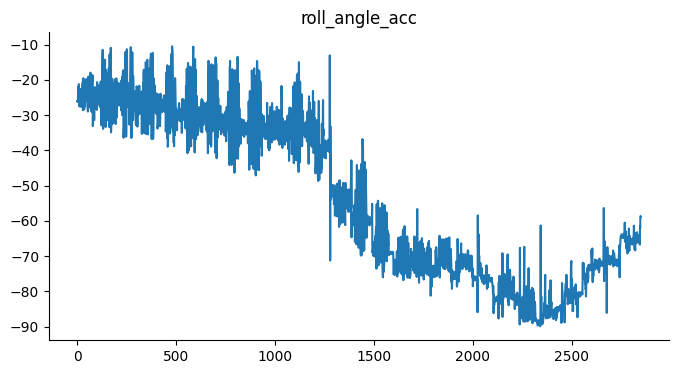

In [ ]:
from matplotlib import pyplot as plt
new_df_imu['roll_angle_acc'].plot(kind='line', figsize=(8, 4), title='roll_angle_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

Function 'calculate_y_from_matlab_snippet' updated successfully.
Resulting y: 53.71346133669985


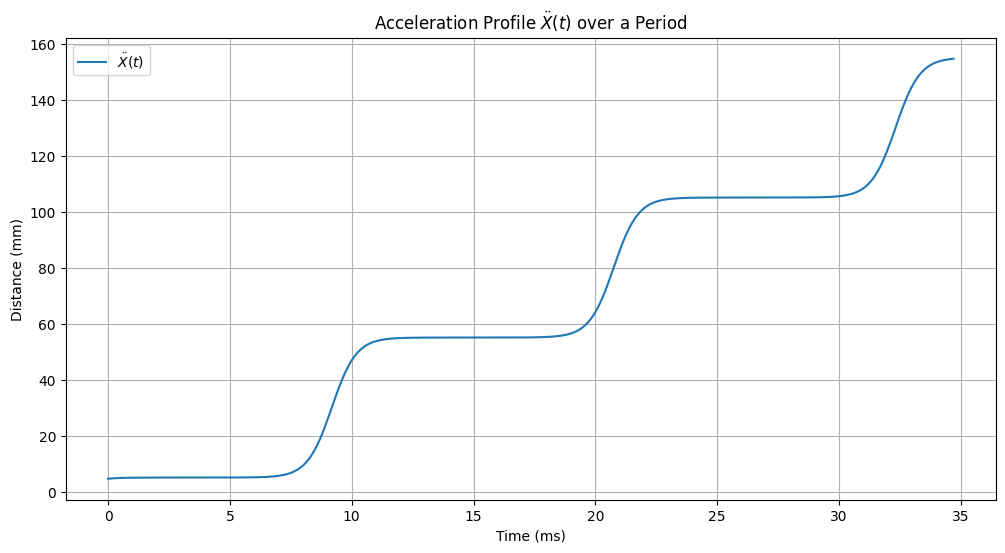

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_y_from_matlab_snippet(x, period, distance, actuation_start, actuation_period):
    x_ = np.remainder(x, period)
    mod = (x - x_) / (period*2) * distance
    y_ = distance * (0.5 + 0.5 * float(np.tanh(((x_ - actuation_start + (actuation_period / 2)))) / 2))
    y = 2*(y_ + mod - 10)
    return y


print("Function 'calculate_y_from_matlab_snippet' updated successfully.")

# Variables
period_val = 11.570
distance_val = 50
actuation_start_val = 8.683
actuation_period_val = 3.000
x_val = 9
result_y = calculate_y_from_matlab_snippet(x_val, period_val, distance_val, actuation_start_val, actuation_period_val)
print(f"Resulting y: {result_y}")

# Lists to store results for plotting
t_values = []
results = []

# Loop through t_val using np.arange to handle float period_val
# np.arange(start, stop, step) generates values from start up to (but not including) stop
for t_val in np.arange(0, 3 * period_val, step=0.1): # Using a small step for better plot resolution
    result = calculate_y_from_matlab_snippet((t_val-2), period_val, distance_val, actuation_start_val, actuation_period_val)
    t_values.append(t_val)
    results.append(result)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(t_values, results, label='$\\ddot{X}(t)$')
plt.xlabel('Time (ms)')
plt.ylabel('Distance (mm)')
plt.title('Acceleration Profile $\\ddot{X}(t)$ over a Period')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
new_df_imu['distance est'] = new_df_imu['timestamp2'].apply(lambda x: calculate_y_from_matlab_snippet(((x/1000)+7), period_val, distance_val, actuation_start_val, actuation_period_val))
# Initialize new columns in new_df_imu with NaN values
new_df_imu['dx'] = 0
new_df_imu['dx'] = new_df_imu['distance est'].diff()
new_df_imu['dx2'] = new_df_imu['dx'].diff()
display(new_df_imu.head())

,timestamp,sequence number,accX,accY,accZ,gyroX,gyroY,gyroZ,filterX,filterY,filterZ,timestamp2,pitch_angle_acc,roll_angle_acc,distance est,dx,dx2
0,64587808,0,-4.53,7.66,-5.23,-1.50,-0.31,-0.37,13.81,-24.19,-124.50,0,-30.442351,-26.030955,25.475396,NaN,NaN
1,64587904,0,-4.57,7.65,-5.21,1.19,0.06,0.06,13.88,-24.19,-124.50,96,-30.313340,-26.278031,27.830471,2.355075,NaN
2,64588033,1,-4.55,7.57,-5.27,1.12,0.06,0.25,13.88,-24.19,-124.50,225,-30.823754,-26.256713,31.049383,3.218912,0.863837
3,64588129,1,-4.46,7.43,-5.27,1.81,0.37,0.56,13.81,-24.19,-124.44,321,-31.305293,-26.087021,33.428265,2.378882,-0.840030
4,64588226,1,-4.34,7.37,-4.96,3.25,-0.25,0.25,13.94,-24.25,-124.50,418,-30.110246,-26.037369,35.769188,2.340923,-0.037959


In [ ]:
import numpy as np

# Calculate the magnitude of the filter vector for each row
new_df_imu['filter_magnitude'] = np.sqrt(new_df_imu['filterX']**2 + new_df_imu['filterY']**2 + new_df_imu['filterZ']**2)

# Calculate the normalized direction vector components
# Handle cases where magnitude might be zero to avoid division by zero
new_df_imu['filter_dirX'] = new_df_imu.apply(lambda row: np.cos(row['filterY'])*np.sin(row['filterZ']) , axis=1)
new_df_imu['filter_dirY'] = new_df_imu.apply(lambda row: np.cos(row['filterY'])*np.cos(row['filterZ']) , axis=1)
new_df_imu['filter_dirZ'] = new_df_imu.apply(lambda row: np.sin(row['filterZ']) , axis=1)


display(new_df_imu[['filterX', 'filterY', 'filterZ', 'filter_magnitude', 'filter_dirX', 'filter_dirY', 'filter_dirZ']].head())

,filterX,filterY,filterZ,filter_magnitude,filter_dirX,filter_dirY,filter_dirZ
0,13.81,-24.19,-124.50,127.577906,0.539554,0.232643,0.918277
1,13.88,-24.19,-124.50,127.585503,0.539554,0.232643,0.918277
2,13.88,-24.19,-124.50,127.585503,0.539554,0.232643,0.918277
3,13.81,-24.19,-124.44,127.519355,0.552533,0.199870,0.940367
4,13.94,-24.25,-124.50,127.603433,0.583139,0.251436,0.918277


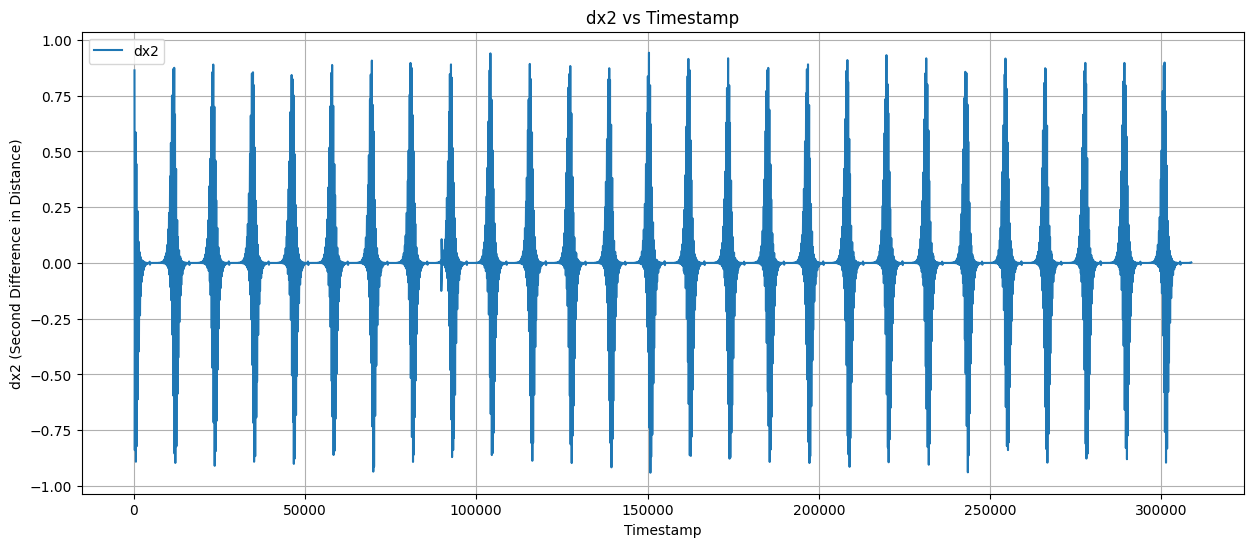

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(new_df_imu['timestamp2'], new_df_imu['dx2'], label='dx2')
plt.xlabel('Timestamp')
plt.ylabel('dx2 (Second Difference in Distance)')
plt.title('dx2 vs Timestamp')
plt.grid(True)
plt.legend()
plt.show()

<Figure size 1500x700 with 0 Axes>

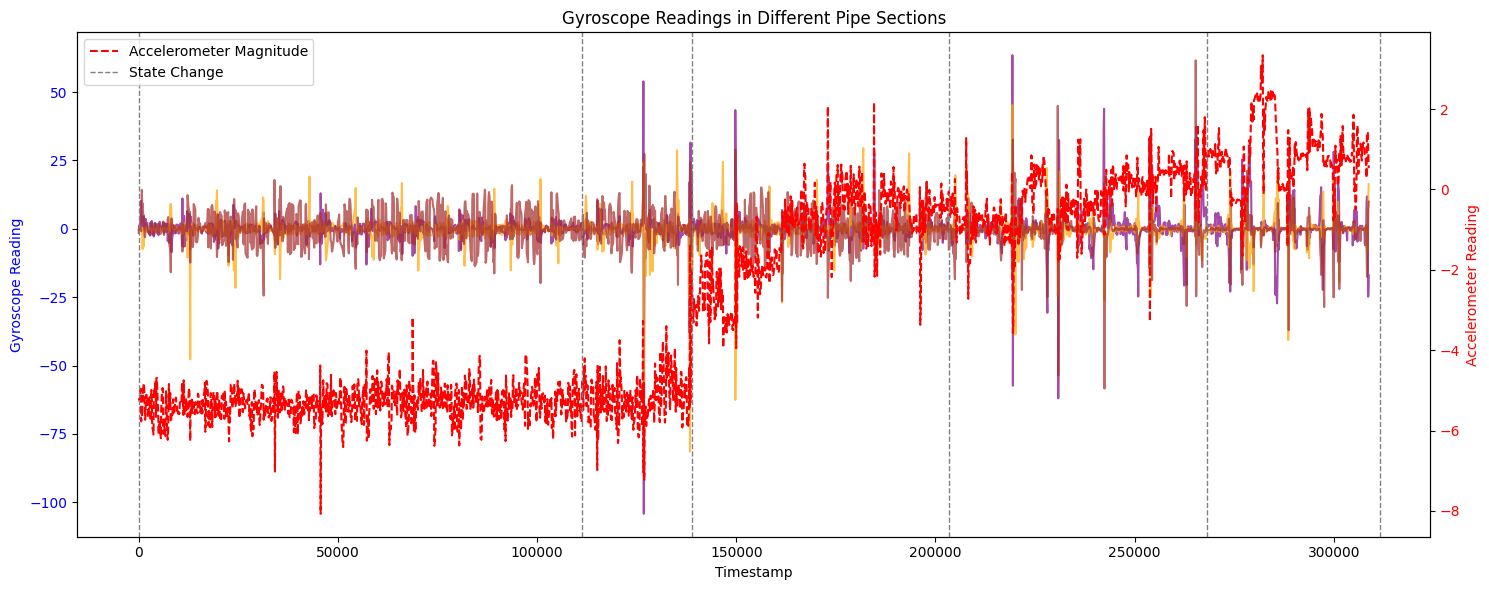

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 7))

fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot dx2 on the primary y-axis
# Plot gyroX
ax1.plot(new_df_imu['timestamp2'], new_df_imu['gyroX'], label='gyroX', color='purple', alpha=0.7)
# Plot gyroY
ax1.plot(new_df_imu['timestamp2'], new_df_imu['gyroY'], label='gyroY', color='orange', alpha=0.7)
# Plot gyroZ
ax1.plot(new_df_imu['timestamp2'], new_df_imu['gyroZ'], label='gyroZ', color='brown', alpha=0.7)
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Gyroscope Reading', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(new_df_imu['timestamp2'], new_df_imu['accZ'], label='Accelerometer Magnitude', color='red', linestyle='--')
ax2.set_ylabel('Accelerometer Reading', color='red')
ax2.tick_params(axis='y', labelcolor='red')


# Add vertical lines for timestamps_at_state_1_changes
for timestamp in timestamps_at_state_1_changes:
    plt.axvline(x=timestamp, color='gray', linestyle='--', linewidth=1, label='State Change' if timestamp == timestamps_at_state_1_changes[0] else "")

plt.xlabel('Timestamp')
plt.ylabel('Accelerometer Reading')
plt.title('Gyroscope Readings in Different Pipe Sections')
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

new_df_imu['acc_magnitude'] = np.sqrt(new_df_imu['accX']**2 + new_df_imu['accY']**2 + new_df_imu['accZ']**2)
display(new_df_imu.head())

,timestamp,sequence number,accX,accY,accZ,gyroX,gyroY,gyroZ,filterX,filterY,...,pitch_angle_acc,roll_angle_acc,distance est,dx,dx2,filter_magnitude,filter_dirX,filter_dirY,filter_dirZ,acc_magnitude
0,64587808,0,-4.53,7.66,-5.23,-1.50,-0.31,-0.37,13.81,-24.19,...,-30.442351,-26.030955,25.475396,NaN,NaN,127.577906,0.539554,0.232643,0.918277,10.322277
1,64587904,0,-4.57,7.65,-5.21,1.19,0.06,0.06,13.88,-24.19,...,-30.313340,-26.278031,27.830471,2.355075,NaN,127.585503,0.539554,0.232643,0.918277,10.322379
2,64588033,1,-4.55,7.57,-5.27,1.12,0.06,0.25,13.88,-24.19,...,-30.823754,-26.256713,31.049383,3.218912,0.863837,127.585503,0.539554,0.232643,0.918277,10.284955
3,64588129,1,-4.46,7.43,-5.27,1.81,0.37,0.56,13.81,-24.19,...,-31.305293,-26.087021,33.428265,2.378882,-0.840030,127.519355,0.552533,0.199870,0.940367,10.142455
4,64588226,1,-4.34,7.37,-4.96,3.25,-0.25,0.25,13.94,-24.25,...,-30.110246,-26.037369,35.769188,2.340923,-0.037959,127.603433,0.583139,0.251436,0.918277,9.887067


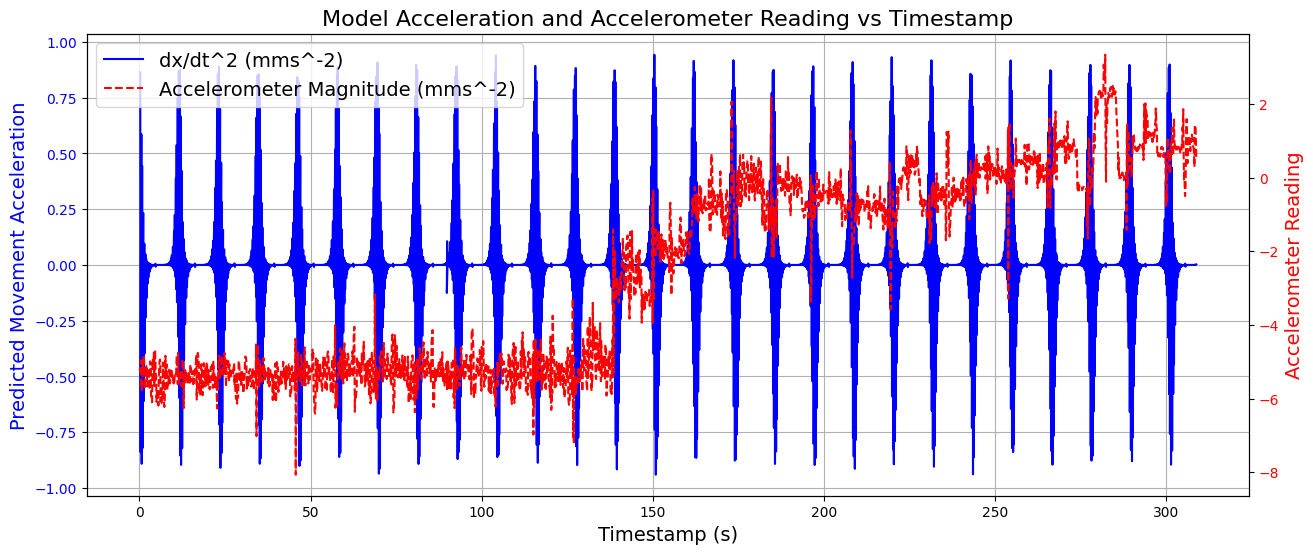

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot dx2 on the primary y-axis
ax1.plot((new_df_imu['timestamp2']/1000), new_df_imu['dx2'], label='dx/dt^2 (mms^-2)', color='blue')
ax1.set_xlabel('Timestamp (s)', fontsize=14)
ax1.set_ylabel('Predicted Movement Acceleration', color='blue', fontsize=14)
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot((new_df_imu['timestamp2']/1000), new_df_imu['accZ'], label='Accelerometer Magnitude (mms^-2)', color='red', linestyle='--')
ax2.set_ylabel('Accelerometer Reading', color='red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='red')

# Add title and grid
plt.title('Model Acceleration and Accelerometer Reading vs Timestamp', fontsize=16)
ax1.grid(True)

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=14)

plt.show()

In [ ]:
import numpy as np # Ensure numpy is imported for np.nan

def custom_combined_pitch_logic(dx2_value, pitch_angle_acc_value):
    # Note: The condition `-0.05 < dx2_value > 0.05` is equivalent to checking if
    # dx2_value is NOT between -0.05 and 0.05. If the intent was for 'High Pitch'
    # when significantly positive and 'Low Pitch' when significantly negative,
    # the previous definition (e.g., `if dx2_value > 0.05: return pitch_angle_acc_value`) might be clearer.
    # Assuming the original intent of the provided condition: dx2_value is either > 0.05 OR < -0.05
    if dx2_value > 0.01 or dx2_value < -0.1:
        return pitch_angle_acc_value
    else:
        return np.nan # Return NaN to be filled by ffill

# Apply the custom function to create the new 'Combined_Pitch_Variable' column
# We use axis=1 to apply the function row-wise
new_df_imu['Combined_Pitch_Variable'] = new_df_imu.apply(lambda row: custom_combined_pitch_logic(row['dx2'], row['pitch_angle_acc']), axis=1)

# Now, forward-fill the NaN values to get the 'last valid' value
new_df_imu['Combined_Pitch_Variable'] = new_df_imu['Combined_Pitch_Variable'].ffill()

# We use axis=1 to apply the function row-wise
new_df_imu['Combined_Roll_Variable'] = new_df_imu.apply(lambda row: custom_combined_pitch_logic(row['dx2'], row['roll_angle_acc']), axis=1)

# Now, forward-fill the NaN values to get the 'last valid' value
new_df_imu['Combined_Roll_Variable'] = new_df_imu['Combined_Roll_Variable'].ffill()

# Display the DataFrame with the new column
display(new_df_imu.head())

,timestamp,sequence number,accX,accY,accZ,gyroX,gyroY,gyroZ,filterX,filterY,...,distance est,dx,dx2,filter_magnitude,filter_dirX,filter_dirY,filter_dirZ,acc_magnitude,Combined_Pitch_Variable,Combined_Roll_Variable
0,64587808,0,-4.53,7.66,-5.23,-1.50,-0.31,-0.37,13.81,-24.19,...,25.475396,NaN,NaN,127.577906,0.539554,0.232643,0.918277,10.322277,NaN,NaN
1,64587904,0,-4.57,7.65,-5.21,1.19,0.06,0.06,13.88,-24.19,...,27.830471,2.355075,NaN,127.585503,0.539554,0.232643,0.918277,10.322379,NaN,NaN
2,64588033,1,-4.55,7.57,-5.27,1.12,0.06,0.25,13.88,-24.19,...,31.049383,3.218912,0.863837,127.585503,0.539554,0.232643,0.918277,10.284955,-30.823754,-26.256713
3,64588129,1,-4.46,7.43,-5.27,1.81,0.37,0.56,13.81,-24.19,...,33.428265,2.378882,-0.840030,127.519355,0.552533,0.199870,0.940367,10.142455,-31.305293,-26.087021
4,64588226,1,-4.34,7.37,-4.96,3.25,-0.25,0.25,13.94,-24.25,...,35.769188,2.340923,-0.037959,127.603433,0.583139,0.251436,0.918277,9.887067,-31.305293,-26.087021


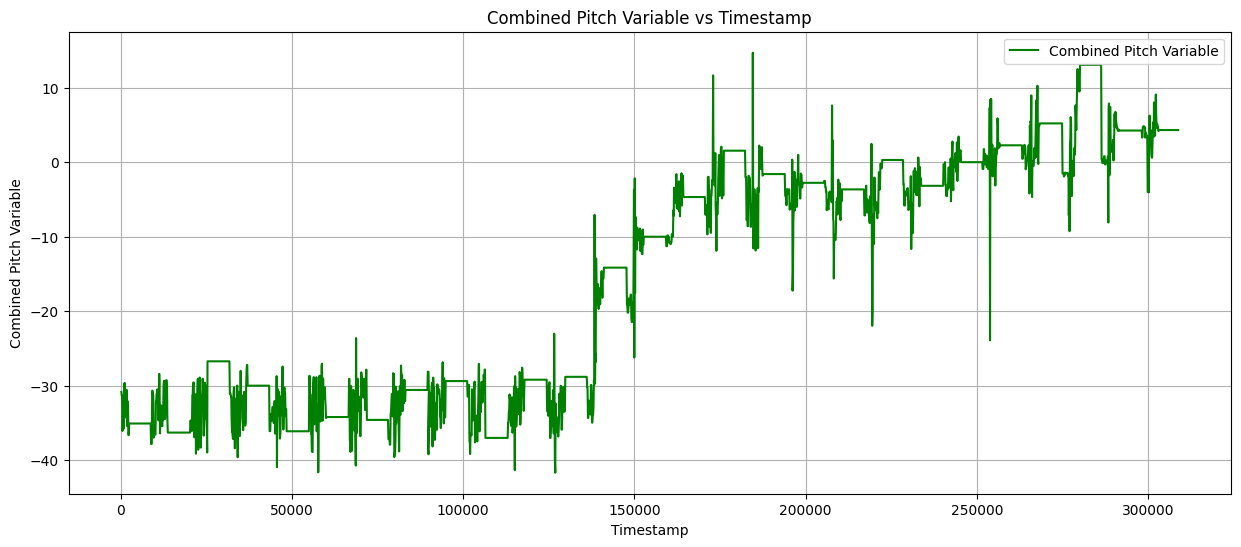

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(new_df_imu['timestamp2'], new_df_imu['Combined_Pitch_Variable'], label='Combined Pitch Variable', color='green')
plt.xlabel('Timestamp')
plt.ylabel('Combined Pitch Variable')
plt.title('Combined Pitch Variable vs Timestamp')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import numpy as np

# Initialize new columns in new_df_imu with NaN values
new_df_imu['straight'] = 1
new_df_imu['mode_state_2_from_interval'] = np.nan

# Iterate through each interval in df_intervals
for index, interval_row in df_intervals.iterrows():
    start_ts = interval_row['timestamp1']
    end_ts = interval_row['timestamp2']
    mode_s1 = interval_row['mode state_1']
    mode_s2 = interval_row['mode_state_2']

    # Create a mask for rows in new_df_imu where timestamp2 falls within the current interval
    mask = (new_df_imu['timestamp2'] >= start_ts) & (new_df_imu['timestamp2'] <= end_ts)

    # Assign the mode values to the corresponding rows in new_df_imu
    new_df_imu.loc[mask, 'straight'] = mode_s1
    new_df_imu.loc[mask, 'junction ahead'] = mode_s2

display(new_df_imu.loc[:,['straight', 'junction ahead']].head(100))

,straight,junction ahead
0,1,NaN
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0
...,...,...
95,1,0.0
96,1,0.0
97,1,0.0
98,1,0.0


In [ ]:
display(new_df_imu[['straight', 'junction ahead']].head())

,straight,junction ahead
0,1,NaN
1,1,0.0
2,1,0.0
3,1,0.0
4,1,0.0


In [ ]:
total_dx_for_straight = new_df_imu[new_df_imu['straight'] == 1]['dx'].sum()
print(f"Total distance moved bar junction lengths is: {total_dx_for_straight/1000}m")

Total distance moved bar junction lengths is: 0.908465427939795m


In [ ]:
# Initialize an empty list to store the split DataFrames
split_dfs = []

# Iterate through each interval in df_intervals
for i, interval_row in df_intervals.iterrows():
    start_ts = interval_row['timestamp1']
    end_ts = interval_row['timestamp2']

    # Filter new_df_imu for the current interval
    current_df_section = new_df_imu[(new_df_imu['timestamp2'] >= start_ts) & (new_df_imu['timestamp2'] <= end_ts)].copy()
    split_dfs.append(current_df_section)

# Assign the split DataFrames to df_1, df_2, df_3, df_4
df_1 = split_dfs[0]
df_2 = split_dfs[1]
df_3 = split_dfs[2]
df_4 = split_dfs[3]
df_5 = split_dfs[4]

#print("new_df_imu has been split into df_1, df_2, df_3, and df_4.")
#print(f"df_1 head:\n{df_1.head()}")
print(f"df_2 head:\n{df_2.head(100)}")
print(f"df_3 head:\n{df_3.head()}")
#print(f"df_4 head:\n{df_4.head()}")

df_2 head:
      timestamp  sequence number  accX  accY  accZ  gyroX  gyroY  gyroZ  \
1030   64699200                5 -4.24  5.48 -4.72   0.88   0.31  -3.81   
1031   64699297                5 -4.18  5.55 -5.22  -5.88  -0.63   5.19   
1032   64699425                5 -6.23  5.82 -5.49  -3.38   1.19  -1.25   
1033   64699521                5 -3.05  6.23 -4.43  -2.13   2.63  -8.25   
1034   64699617                5 -4.27  6.75 -4.71  -2.00   2.31  -8.25   
...         ...              ...   ...   ...   ...    ...    ...    ...   
1125   64709512                4 -7.86  6.47 -5.67  -0.63   0.81   0.25   
1126   64709608                4 -8.29  6.78 -5.53  -0.37  -0.31   4.13   
1127   64709705                4 -2.84  5.69 -5.01  -0.25  -1.06   6.63   
1128   64709833                4 -4.06  5.60 -5.09  -0.69  -1.56   6.06   
1129   64709930                4 -5.78  6.00 -5.14  -0.75  -0.88   4.25   

      filterX  filterY  ...  filter_magnitude  filter_dirX  filter_dirY  \
1030    39.63

In [ ]:
avg_cpv_df1 = df_1['Combined_Pitch_Variable'].mean()
avg_paa_df1 = df_1['pitch_angle_acc'].mean()
print(f"df_1 - Average Combined_Pitch_Variable: {avg_cpv_df1}")
print(f"df_1 - Average pitch_angle_acc: {avg_paa_df1}\n")

avg_cpv_df3 = df_3['Combined_Pitch_Variable'].mean()
avg_paa_df3 = df_3['pitch_angle_acc'].mean()
print(f"df_3 - Average Combined_Pitch_Variable: {avg_cpv_df3}")
print(f"df_3 - Average pitch_angle_acc: {avg_paa_df3}")

avg_cpv_df5 = df_5['Combined_Pitch_Variable'].mean()
avg_paa_df5 = df_5['pitch_angle_acc'].mean()
print(f"df_5 - Average Combined_Pitch_Variable: {avg_cpv_df5}")
print(f"df_5 - Average pitch_angle_acc: {avg_paa_df5}")

df_1 - Average Combined_Pitch_Variable: -32.89587520867958
df_1 - Average pitch_angle_acc: -32.91020623760594

df_3 - Average Combined_Pitch_Variable: -6.336147415012952
df_3 - Average pitch_angle_acc: -6.8029591075699525
df_5 - Average Combined_Pitch_Variable: 5.122100379677458
df_5 - Average pitch_angle_acc: 5.141927911672801


In [ ]:
total_dx_for_straight = df_3[new_df_imu['straight'] == 1]['dx'].sum()
print(f"Total distance moved bar junction lengths is: {total_dx_for_straight/1000}m")

Total distance moved bar junction lengths is: 0.277493224489577m


/tmp/ipython-input-2545831625.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [ ]:
sum_dx_df1 = df_1['dx'].sum()
sum_dx_df3 = df_3['dx'].sum()
sum_dx_df5 = df_5['dx'].sum()

print(f"Sum of 'dx' for df_1: {sum_dx_df1}")
print(f"Sum of 'dx' for df_3: {sum_dx_df3}")
print(f"Sum of 'dx' for df_5: {sum_dx_df5}")

#493.38
#204.87
#45.66

#492.83
#249.77
#186.67

#493.84
#283.87
#198.54


Sum of 'dx' for df_1: 479.5297783973879
Sum of 'dx' for df_3: 277.49322448957696
Sum of 'dx' for df_5: 151.44242505283023


In [ ]:
import numpy as np

p1 = -25
p2 = 0
p3 = 0

ds1_p1 = -24.29123795032235
ds1_p2 = 4.440225255822763 # 0.07 rad
ds1_p3 = 6.516240473640311 # 0.1 rad

ds2_p1 = -25.317088248157702
ds2_p2 = -2.0515054013874856
ds2_p3 = 5.392831299791084

#avg error = 4.6 degrees

_p1 = np.array([0, 0])
_p2 = np.array([10 * np.cos(np.radians(p1)), 10 * np.sin(np.radians(p1))])
_p3 = _p2 + np.array([10, 0])
_p4 = _p3 + np.array([10, 0])

d1_p1 = np.array([0, 0])
d1_p2 = np.array([10 * np.cos(np.radians(ds1_p1)), 10 * np.sin(np.radians(ds1_p1))])
d1_p3 = d1_p2 + np.array([10 * np.cos(np.radians(ds1_p2)), 10 * np.sin(np.radians(ds1_p2))])
d1_p4 = d1_p3 + np.array([10 * np.cos(np.radians(ds1_p3)), 10 * np.sin(np.radians(ds1_p3))])

d2_p1 = np.array([0, 0])
d2_p2 = np.array([10* np.cos(np.radians(ds2_p1)), 10 * np.sin(np.radians(ds2_p1))])
d2_p3 = d2_p2 + np.array([10 * np.cos(np.radians(ds2_p2)), 10 * np.sin(np.radians(ds2_p2))])
d2_p4 = d2_p3 + np.array([10 * np.cos(np.radians(ds2_p3)), 10 * np.sin(np.radians(ds2_p3))])

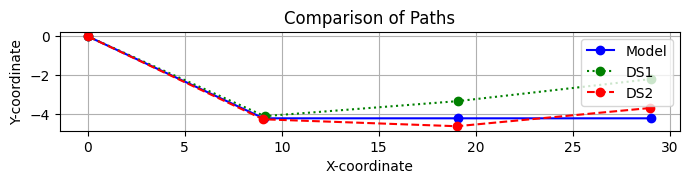

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot Model path
model_x = [_p1[0], _p2[0], _p3[0], _p4[0]]
model_y = [_p1[1], _p2[1], _p3[1], _p4[1]]
plt.plot(model_x, model_y, marker='o', linestyle='-', color='blue', label='Model')

# Plot DS1 path
ds1_x = [d1_p1[0], d1_p2[0], d1_p3[0], d1_p4[0]]
ds1_y = [d1_p1[1], d1_p2[1], d1_p3[1], d1_p4[1]]
plt.plot(ds1_x, ds1_y, marker='o', linestyle=':', color='green', label='DS1')

# Plot DS2 path
ds2_x = [d2_p1[0], d2_p2[0], d2_p3[0], d2_p4[0]]
ds2_y = [d2_p1[1], d2_p2[1], d2_p3[1], d2_p4[1]]
plt.plot(ds2_x, ds2_y, marker='o', linestyle='--', color='red', label='DS2')

plt.title('Comparison of Paths')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box') # Ensure equal scaling for x and y axes
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
import numpy as np

# 1. Define the given vector
v = np.array([0, np.cos(np.radians(-1.73)), np.sin(np.radians(-1.73))])

# 2. Normalize the given vector
v_norm = np.linalg.norm(v)
v_hat = v / v_norm

# 3. Define the desired angle (135 degrees)
angle_degrees = 90
angle_radians = np.radians(angle_degrees)

# Cosine and sine of the desired angle
cos_alpha = np.cos(angle_radians)
sin_alpha = np.sin(angle_radians)

# 4. Find two orthonormal vectors (a, b) that are orthogonal to v_hat.
# These vectors will form a basis for the plane perpendicular to v_hat.
# We use cross products for this, ensuring 'a' is not parallel to 'v_hat'.
temp_vec = np.array([1, 0, 0])
# If v_hat is parallel to temp_vec, choose another arbitrary vector (e.g., [0,0,1])
if np.allclose(np.cross(v_hat, temp_vec), np.zeros(3)):
    temp_vec = np.array([0, 0, 1])

a = np.cross(v_hat, temp_vec)
a = a / np.linalg.norm(a) # Ensure 'a' is a unit vector

# Second orthogonal vector 'b': cross v_hat with 'a'
b = np.cross(v_hat, a)
# 'b' will also be a unit vector and orthogonal to both v_hat and a

# 5. Generate theta values for the azimuthal angle around v_hat
# 0 < theta < 2pi, at increments of 0.01pi
theta_values = np.arange(0.01 * np.pi, 2 * np.pi, 0.01 * np.pi)

# 6. Initialize a list to store the resulting vectors
result_vectors = []

# 7. For each theta, construct a unit vector 'u_hat' that lies on the cone
# with v_hat as its axis, and 'alpha' as the cone angle.
for theta in theta_values:
    # Formula for a vector on a cone:
    # u_hat = cos(alpha) * v_hat + sin(alpha) * (cos(theta) * a + sin(theta) * b)
    u_hat = cos_alpha * v_hat + sin_alpha * (np.cos(theta) * a + np.sin(theta) * b)
    result_vectors.append(u_hat)

# Convert the list of arrays to a single NumPy array for convenience
result_vectors_np = np.array(result_vectors)

# Display the shape and a few examples of the generated vectors
print(f"Generated {len(result_vectors_np)} vectors.")
print("Shape of the result array:", result_vectors_np.shape)
print("\nFirst 5 generated vectors:")
for i in range(5):
    print(result_vectors_np[i])

# Optional: Verify one of the vectors to ensure it meets the condition
print("\nVerification for the first vector:")
test_vector = result_vectors_np[0]
dot_product_test = np.dot(test_vector, v_hat)
# Clip dot product to handle potential floating point errors that push it slightly out of [-1, 1]
angle_test = np.degrees(np.arccos(np.clip(dot_product_test, -1.0, 1.0)))
print(f"Dot product of first generated vector with v_hat: {dot_product_test:.4f}")
print(f"Expected cos({angle_degrees} degrees): {cos_alpha:.4f}")
print(f"Angle between first generated vector and v: {angle_test:.2f} degrees")
print(f"Magnitude of first generated vector: {np.linalg.norm(test_vector):.4f}")

Generated 199 vectors.
Shape of the result array: (199, 3)

First 5 generated vectors:
[-0.03141076 -0.03017471 -0.99905098]
[-0.06279052 -0.03013004 -0.99757182]
[-0.09410831 -0.03005563 -0.99510818]
[-0.12533323 -0.02995155 -0.99166249]
[-0.15643447 -0.02981792 -0.98723814]

Verification for the first vector:
Dot product of first generated vector with v_hat: 0.0000
Expected cos(90 degrees): 0.0000
Angle between first generated vector and v: 90.00 degrees
Magnitude of first generated vector: 1.0000


(-1.2, 1.2)

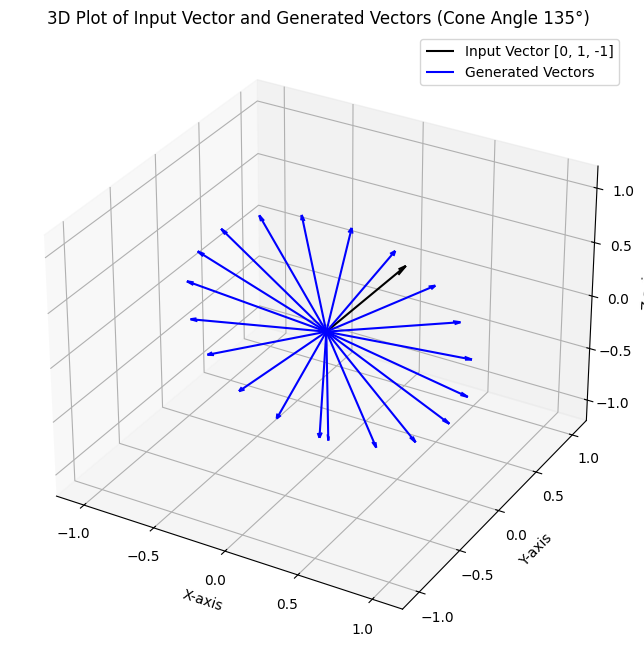

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the input vector (v)
ax.quiver(0, 0, 0, v[0], v[1], v[2], color='black', label='Input Vector [0, 1, -1]', arrow_length_ratio=0.1)

# Plot a subset (e.g., 20) of the generated vectors
num_vectors_to_plot = 20
sample_indices = np.linspace(0, len(result_vectors_np) - 1, num_vectors_to_plot, dtype=int)

for i, idx in enumerate(sample_indices):
    vec = result_vectors_np[idx]
    if i == 0: # Add label only once for the legend
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='blue', label='Generated Vectors', arrow_length_ratio=0.05)
    else:
        ax.quiver(0, 0, 0, vec[0], vec[1], vec[2], color='blue', arrow_length_ratio=0.05)

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Plot of Input Vector and Generated Vectors (Cone Angle 135°)')
ax.legend()

# Set limits to ensure all vectors are visible
max_val = np.max(np.abs(v))
for vec in result_vectors_np:
    max_val = np.max([max_val, np.max(np.abs(vec))])
limit = max_val * 1.2 # Add some padding
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])
ax.set_zlim([-limit, limit])

#plt.show()

In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assuming 'v' (input vector) and 'result_vectors_np' (generated vectors) are already defined
# from previous cells.

fig = go.Figure()

# Add the input vector (v)
fig.add_trace(go.Scatter3d(
    x=[0, v[0]], y=[0, v[1]], z=[0, v[2]],
    mode='lines+markers',
    line=dict(color='black', width=4),
    marker=dict(size=4),
    name='Input Vector [0, 1, -1]'
))

# Plot a subset of the generated vectors for clarity
num_vectors_to_plot = 20 # Can adjust this number
sample_indices = np.linspace(0, len(result_vectors_np) - 1, num_vectors_to_plot, dtype=int)

for i, idx in enumerate(sample_indices):
    vec = result_vectors_np[idx]
    fig.add_trace(go.Scatter3d(
        x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
        mode='lines',
        line=dict(color='blue', width=2),
        showlegend=False if i > 0 else True, # Show legend only for the first one
        name='Generated Vectors' if i == 0 else ''
    ))

# Update layout for a better 3D view
fig.update_layout(
    title='Interactive 3D Plot of Input Vector and Generated Vectors (Cone Angle 135°)',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        aspectmode='cube' # Ensures equal scaling for axes
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [ ]:
import numpy as np

# Reuse the calculate_vector_pitch function from the previous cell if it's not already in scope
def calculate_vector_pitch(vector):
    """Calculates the pitch angle from a 3D vector [x, y, z] in degrees.
    Assumes Z is the vertical component and X, Y are horizontal components.
    """
    x, y, z = vector[0], vector[1], vector[2]
    horizontal_magnitude = np.sqrt(x**2 + y**2)
    if horizontal_magnitude == 0:
        return np.degrees(np.arctan2(z, 0.000001)) # Return +/-90 if purely vertical
    return np.degrees(np.arctan2(z, horizontal_magnitude))


target_pitch_radians = ds2_p2
target_pitch_degrees = ds2_p3 #np.degrees(target_pitch_radians)

closest_vector_rad = None
min_pitch_difference_rad = float('inf')
closest_pitch_degrees_rad = None

for vec in result_vectors_np:
    current_pitch_degrees = calculate_vector_pitch(vec)
    pitch_difference_degrees = abs(current_pitch_degrees - target_pitch_degrees)

    if pitch_difference_degrees < min_pitch_difference_rad:
        min_pitch_difference_rad = pitch_difference_degrees
        closest_vector_rad = vec
        closest_pitch_degrees_rad = current_pitch_degrees

print(f"Target Pitch: {target_pitch_radians:.2f} radians ({target_pitch_degrees:.2f} degrees)")
print(f"Vector with Pitch Closest to {target_pitch_radians:.2f} radians:")
print(f"  Vector: {closest_vector_rad}")
print(f"  Calculated Pitch: {closest_pitch_degrees_rad:.2f} degrees (approximately {np.radians(closest_pitch_degrees_rad):.2f} radians)")

Target Pitch: -2.05 radians (5.39 degrees)
Vector with Pitch Closest to -2.05 radians:
  Vector: [0.99556196 0.00284109 0.09406542]
  Calculated Pitch: 5.40 degrees (approximately 0.09 radians)


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assuming 'v', 'result_vectors_np', 'closest_vector_rad', and 'second_output_vector' are already defined

fig = go.Figure()

# Add the input vector (v)
fig.add_trace(go.Scatter3d(
    x=[0, v[0]], y=[0, v[1]], z=[0, v[2]],
    mode='lines+markers',
    line=dict(color='black', width=4),
    marker=dict(size=4),
    name='Input Vector [0, 1, -1]'
))

# Plot a subset of the generated vectors for context (cone)
num_vectors_to_plot = 20 # Can adjust this number
sample_indices = np.linspace(0, len(result_vectors_np) - 1, num_vectors_to_plot, dtype=int)

for i, idx in enumerate(sample_indices):
    vec = result_vectors_np[idx]
    fig.add_trace(go.Scatter3d(
        x=[0, vec[0]], y=[0, vec[1]], z=[0, vec[2]],
        mode='lines',
        line=dict(color='blue', width=1),
        showlegend=False if i > 0 else True,
        name='Generated Cone Vectors'
    ))

# Add the first closest resultant vector
if closest_vector_rad is not None:
    fig.add_trace(go.Scatter3d(
        x=[0, closest_vector_rad[0]], y=[0, closest_vector_rad[1]], z=[0, closest_vector_rad[2]],
        mode='lines+markers',
        line=dict(color='red', width=5),
        marker=dict(size=6, symbol='diamond'),
        name='Closest Pitch Vector (0.1 rad)'
    ))

# Update layout for a better 3D view
fig.update_layout(
    title='Interactive 3D Plot: Input, Cone, and Output Vectors',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis',
        aspectmode='cube'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [ ]:
import numpy as np

def calculate_yaw(vector):
    """Calculates the yaw angle from a 3D vector [x, y, z] in degrees.
    Assumes yaw is the angle in the XY-plane relative to the positive X-axis.
    """
    x, y = vector[0], vector[1]
    # np.arctan2(y, x) computes the angle in radians, then convert to degrees
    return np.degrees(np.arctan2(y, x))

# Calculate yaw for the input vector 'v'
yaw_v = calculate_yaw(v)

# Calculate yaw for the closest resultant vector 'closest_vector_rad'
yaw_closest_vector = calculate_yaw(closest_vector_rad)

# Calculate the absolute difference in yaw angles
yaw_difference = abs(yaw_v - yaw_closest_vector)

print(f"Yaw angle of the input vector (v): {yaw_v:.2f} degrees")
print(f"Yaw angle of the closest output vector: {yaw_closest_vector:.2f} degrees")
print(f"Absolute difference in yaw angles: {yaw_difference:.2f} degrees")

Yaw angle of the input vector (v): 90.00 degrees
Yaw angle of the closest output vector: 0.16 degrees
Absolute difference in yaw angles: 89.84 degrees


In [ ]:
gt_pitch1 = -25*np.pi / 180
gt_pitch2 = 0
gt_pitch3 = 0

gt_yaw1 = 0
gt_yaw2 = 40.6*np.pi / 180
gt_yaw3 = 130.6*np.pi / 180

In [ ]:
ds1_pitch1 = -24.29*np.pi / 180
ds1_pitch2 = 4.46*np.pi / 180
ds1_pitch3 = 5.38*np.pi / 180

ds1_yaw1 = 0
ds1_yaw2 = 35.02*np.pi / 180
ds1_yaw3 = 125*np.pi / 180

In [ ]:
ds2_pitch1 = -25.31*np.pi / 180
ds2_pitch2 = -1.73*np.pi / 180
ds2_pitch3 = 5.40*np.pi / 180

ds2_yaw1 = 0
ds2_yaw2 = 39.8*np.pi / 180
ds2_yaw3 = 129.64*np.pi / 180

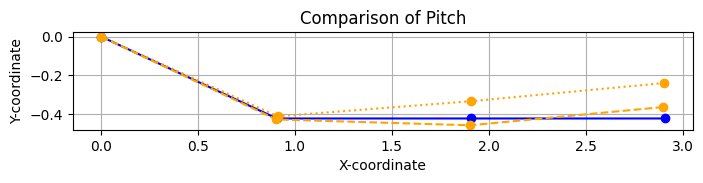

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Plot Model path
gt_x = [0, np.cos(gt_pitch1), np.cos(gt_pitch1) + np.cos(gt_pitch2), np.cos(gt_pitch1) + np.cos(gt_pitch2) + np.cos(gt_pitch3)]
gt_y = [0, np.sin(gt_pitch1), np.sin(gt_pitch1) + np.sin(gt_pitch2), np.sin(gt_pitch1) + np.sin(gt_pitch2) + np.sin(gt_pitch3)]
plt.plot(gt_x, gt_y, marker='o', linestyle='-', color='blue', label='Truth')

# Plot DS1 path
ds1_x = [0, np.cos(ds1_pitch1), np.cos(ds1_pitch1) + np.cos(ds1_pitch2), np.cos(ds1_pitch1) + np.cos(ds1_pitch2) + np.cos(ds1_pitch3)]
ds1_y = [0, np.sin(ds1_pitch1), np.sin(ds1_pitch1) + np.sin(ds1_pitch2), np.sin(ds1_pitch1) + np.sin(ds1_pitch2) + np.sin(ds1_pitch3)]
plt.plot(ds1_x, ds1_y, marker='o', linestyle=':', color='orange', label='DS1')

# Plot DS2 path
ds2_x = [0, np.cos(ds2_pitch1), np.cos(ds2_pitch1) + np.cos(ds2_pitch2), np.cos(ds2_pitch1) + np.cos(ds2_pitch2) + np.cos(ds2_pitch3)]
ds2_y = [0, np.sin(ds2_pitch1), np.sin(ds2_pitch1) + np.sin(ds2_pitch2), np.sin(ds2_pitch1) + np.sin(ds2_pitch2) + np.sin(ds2_pitch3)]
plt.plot(ds2_x, ds2_y, marker='o', linestyle='--', color='orange', label='DS2')

plt.title('Comparison of Pitch')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box') # Ensure equal scaling for x and y axes
#plt.legend(loc = 'upper right')
plt.show()

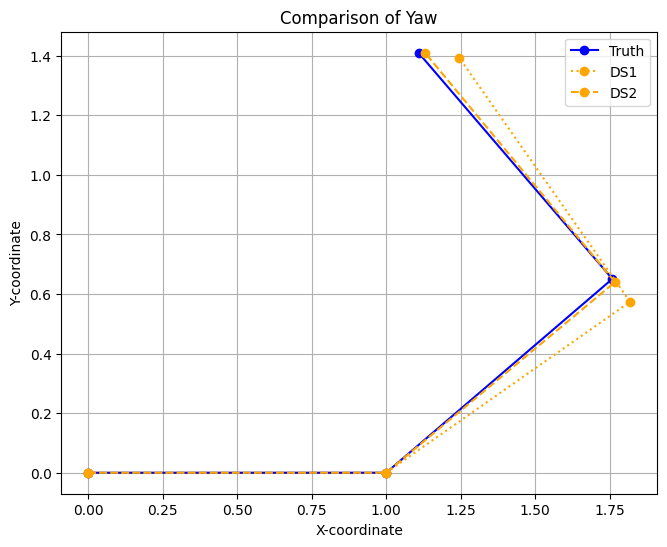

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Plot Model path
gt_x = [0, np.cos(gt_yaw1), np.cos(gt_yaw1) + np.cos(gt_yaw2), np.cos(gt_yaw1) + np.cos(gt_yaw2) + np.cos(gt_yaw3)]
gt_y = [0, np.sin(gt_yaw1), np.sin(gt_yaw1) + np.sin(gt_yaw2), np.sin(gt_yaw1) + np.sin(gt_yaw2) + np.sin(gt_yaw3)]
plt.plot(gt_x, gt_y, marker='o', linestyle='-', color='blue', label='Truth')

# Plot DS1 path
ds1_x = [0, np.cos(ds1_yaw1), np.cos(ds1_yaw1) + np.cos(ds1_yaw2), np.cos(ds1_yaw1) + np.cos(ds1_yaw2) + np.cos(ds1_yaw3)]
ds1_y = [0, np.sin(ds1_yaw1), np.sin(ds1_yaw1) + np.sin(ds1_yaw2), np.sin(ds1_yaw1) + np.sin(ds1_yaw2) + np.sin(ds1_yaw3)]
plt.plot(ds1_x, ds1_y, marker='o', linestyle=':', color='orange', label='DS1')

# Plot DS2 path
ds2_x = [0, np.cos(ds2_yaw1), np.cos(ds2_yaw1) + np.cos(ds2_yaw2), np.cos(ds2_yaw1) + np.cos(ds2_yaw2) + np.cos(ds2_yaw3)]
ds2_y = [0, np.sin(ds2_yaw1), np.sin(ds2_yaw1) + np.sin(ds2_yaw2), np.sin(ds2_yaw1) + np.sin(ds2_yaw2) + np.sin(ds2_yaw3)]
plt.plot(ds2_x, ds2_y, marker='o', linestyle='--', color='orange', label='DS2')

plt.title('Comparison of Yaw')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box') # Ensure equal scaling for x and y axes
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
ds1_d1 = 493.38 + 250
ds1_d2 = 204.87
ds1_d3 = 45.66 + 250

ds2_d1 = 492.83 + 250
ds2_d2 = 249.77
ds2_d3 = 186.67 + 250



In [ ]:
d1 = 493.38 + 250
e1 = 204.87

d2 = 492.83 + 250
e2 = 249.77

d3 = 493.84 + 250
e3 = 283.87

d = (d1 + d2 + d3)/3
error1 = 750 - d
print(error1)

e = (e1 + e2 + e3)/3
print(300 - e)

6.649999999999977
53.83000000000001


In [ ]:
import numpy as np
import plotly.graph_objects as go

# Helper function to convert spherical coordinates to Cartesian
def spherical_to_cartesian(length, pitch, yaw):
    """Converts spherical coordinates (length, pitch, yaw) to Cartesian [x, y, z].
    Pitch: angle with the XY-plane (elevation).
    Yaw: angle in the XY-plane relative to the positive X-axis (azimuth).
    """
    x = length * np.cos(pitch) * np.cos(yaw)
    y = length * np.cos(pitch) * np.sin(yaw)
    z = length * np.sin(pitch)
    return np.array([x, y, z])

# Define vector length
gt_vector_length_1 = 750
gt_vector_length_2 = 300
gt_vector_length_3 = 400

# Define vector length
ds1_vector_length_1 = ds1_d1
ds1_vector_length_2 = ds1_d2
ds1_vector_length_3 = ds1_d3

# Define vector length
ds2_vector_length_1 = ds2_d1
ds2_vector_length_2 = ds2_d2
ds2_vector_length_3 = ds2_d3

# Initialize current position and list to store path points for Ground Truth (gt)
current_position_gt = np.array([0.0, 0.0, 0.0])
path_points_gt = [current_position_gt.tolist()] # Start with the origin

# Calculate and add the first vector for gt
vector1_gt = spherical_to_cartesian(gt_vector_length_1, gt_pitch1, -gt_yaw1)
current_position_gt = current_position_gt + vector1_gt
path_points_gt.append(current_position_gt.tolist())

# Calculate and add the second vector for gt
vector2_gt = spherical_to_cartesian(gt_vector_length_2, gt_pitch2, -gt_yaw2)
current_position_gt = current_position_gt + vector2_gt
path_points_gt.append(current_position_gt.tolist())

# Calculate and add the third vector for gt
vector3_gt = spherical_to_cartesian(gt_vector_length_3, gt_pitch3, -gt_yaw3)
current_position_gt = current_position_gt + vector3_gt
path_points_gt.append(current_position_gt.tolist())

# Convert path_points_gt to a numpy array for easier plotting
path_points_gt = np.array(path_points_gt)

# Initialize current position and list to store path points for DS1
current_position_ds1 = np.array([0.0, 0.0, 0.0])
path_points_ds1 = [current_position_ds1.tolist()] # Start with the origin

# Calculate and add the first vector for ds1
vector1_ds1 = spherical_to_cartesian(ds1_vector_length_1, ds1_pitch1, -ds1_yaw1)
current_position_ds1 = current_position_ds1 + vector1_ds1
path_points_ds1.append(current_position_ds1.tolist())

# Calculate and add the second vector for ds1
vector2_ds1 = spherical_to_cartesian(ds1_vector_length_2, ds1_pitch2, -ds1_yaw2)
current_position_ds1 = current_position_ds1 + vector2_ds1
path_points_ds1.append(current_position_ds1.tolist())

# Calculate and add the third vector for ds1
vector3_ds1 = spherical_to_cartesian(ds1_vector_length_3, ds1_pitch3, -ds1_yaw3)
current_position_ds1 = current_position_ds1 + vector3_ds1
path_points_ds1.append(current_position_ds1.tolist())

# Convert path_points_ds1 to a numpy array for easier plotting
path_points_ds1 = np.array(path_points_ds1)

# Initialize current position and list to store path points for DS2
current_position_ds2 = np.array([0.0, 0.0, 0.0])
path_points_ds2 = [current_position_ds2.tolist()] # Start with the origin

# Calculate and add the first vector for ds2
vector1_ds2 = spherical_to_cartesian(ds2_vector_length_1, ds2_pitch1, -ds2_yaw1)
current_position_ds2 = current_position_ds2 + vector1_ds2
path_points_ds2.append(current_position_ds2.tolist())

# Calculate and add the second vector for ds2
vector2_ds2 = spherical_to_cartesian(ds2_vector_length_2, ds2_pitch2, -ds2_yaw2)
current_position_ds2 = current_position_ds2 + vector2_ds2
path_points_ds2.append(current_position_ds2.tolist())

## CREATE ARCH -------------------------------------------------------------

ARC_ds2 = np.array(current_position_ds2.tolist())
path_points_arc = [ARC_ds2.tolist()]

vector2_ds2 = spherical_to_cartesian(300, ds2_pitch2, -ds2_yaw2)
current_position_arc = current_position_ds2 + vector2_ds2
path_points_arc.append(current_position_arc.tolist())

vector2_ds2 = spherical_to_cartesian(300, ds2_pitch3, -ds2_yaw3)
current_position_arc = current_position_arc + vector2_ds2
path_points_arc.append(current_position_arc.tolist())

current_position_ds2 = current_position_arc

# -----------------------------------------------------------------------

# Calculate and add the third vector for ds2
vector3_ds2 = spherical_to_cartesian(ds2_vector_length_3, ds2_pitch3, -ds2_yaw3)
current_position_ds2 = current_position_ds2 + vector3_ds2
path_points_ds2.append(current_position_ds2.tolist())


# Convert path_points_ds2 to a numpy array for easier plotting
path_points_ds2 = np.array(path_points_ds2)

# Create the 3D plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=path_points_gt[:, 0],
            y=path_points_gt[:, 1],
            z=path_points_gt[:, 2],
            mode='lines+markers',
            marker=dict(size=5, color='blue'),
            line=dict(color='blue', width=10),
            name='Ground Truth Path'
        ),
        go.Scatter3d(
            x=path_points_ds1[:, 0],
            y=path_points_ds1[:, 1],
            z=path_points_ds1[:, 2],
            mode='lines+markers',
            marker=dict(size=5, color='green'),
            line=dict(color='green', width=10),
            name='DS1 Path'
        ),
        go.Scatter3d(
            x=path_points_ds2[:, 0],
            y=path_points_ds2[:, 1],
            z=path_points_ds2[:, 2],
            mode='lines+markers',
            marker=dict(size=5, color='red'),
            line=dict(color='red', width=10),
            name='DS2 Path'
        )
    ]
)

# Update layout for better visualization
fig.update_layout(
    title='3D Tube Path with Ground Truth, DS1, and DS2 Pitch and Yaw',
    scene=dict(
        xaxis_title='X-coordinate',
        yaxis_title='Y-coordinate',
        zaxis_title='Z-coordinate',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.5)
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()
print("Generated 3D plot for ground truth, DS1, and DS2 vectors.")

Generated 3D plot for ground truth, DS1, and DS2 vectors.


In [ ]:
import numpy as np
import plotly.graph_objects as go
from scipy.interpolate import CubicSpline

# Helper function to convert spherical coordinates to Cartesian
def spherical_to_cartesian(length, pitch, yaw):
    """Converts spherical coordinates (length, pitch, yaw) to Cartesian [x, y, z].
    Pitch: angle with the XY-plane (elevation).
    Yaw: angle in the XY-plane relative to the positive X-axis (azimuth).
    """
    x = length * np.cos(pitch) * np.cos(yaw)
    y = length * np.cos(pitch) * np.sin(yaw)
    z = length * np.sin(pitch)
    return np.array([x, y, z])

# Define vector length
gt_vector_length_1 = 750
gt_vector_length_2 = 300
gt_vector_length_3 = 400

# Define vector length
ds1_vector_length_1 = ds1_d1
ds1_vector_length_2 = ds1_d2
ds1_vector_length_3 = 400

# Define vector length
ds2_vector_length_1 = ds2_d1
ds2_vector_length_2 = ds2_d2
ds2_vector_length_3 = 400


# Initialize current position and list to store path points for Ground Truth (gt)
current_position_gt = np.array([0.0, 0.0, 0.0])
path_points_gt = [current_position_gt.tolist()] # Start with the origin

# Calculate and add the first vector for gt
vector1_gt = spherical_to_cartesian(gt_vector_length_1, gt_pitch1, -gt_yaw1)
current_position_gt = current_position_gt + vector1_gt
path_points_gt.append(current_position_gt.tolist())

# CREATE ELBOW ------------------------------------------

# 2. Define the three control points
control_point1 = current_position_gt

# This is the end of the second segment if it were discrete
vector2_gt_discrete = spherical_to_cartesian(15, gt_pitch1, -gt_yaw1)
control_point2 = control_point1 + vector2_gt_discrete

# This is the end of the third segment if it were discrete
vector3_gt_discrete = spherical_to_cartesian(15, gt_pitch2, -gt_yaw2)
control_point3 = control_point2 + vector3_gt_discrete

# 3. Create a parameter array for the spline
t = np.array([0, 1, 2])

# 4. Create CubicSpline instances for each coordinate (x, y, z)
cs_x = CubicSpline(t, [control_point1[0], control_point2[0], control_point3[0]])
cs_y = CubicSpline(t, [control_point1[1], control_point2[1], control_point3[1]])
cs_z = CubicSpline(t, [control_point1[2], control_point2[2], control_point3[2]])

# 5. Generate a denser array of 'time' values
t_dense = np.linspace(0, 2, 100) # 100 points for a smoother curve

# 6. Evaluate each CubicSpline instance with t_dense
arc_x = cs_x(t_dense)
arc_y = cs_y(t_dense)
arc_z = cs_z(t_dense)

# 7. Combine these interpolated coordinates into a single NumPy array
path_points_arc = np.vstack((arc_x, arc_y, arc_z)).T

# The final position of DS2 after the arc is the last point of the spline
current_position_gt = path_points_arc[-1]

# The path_points_ds2 should now start with the initial straight segment
# and then extend the interpolated arc points.
path_points_gt.extend(path_points_arc.tolist())

#-------------------- el

# Calculate and add the second vector for gt
vector2_gt = spherical_to_cartesian(gt_vector_length_2, gt_pitch2, -gt_yaw2)
current_position_gt = current_position_gt + vector2_gt
path_points_gt.append(current_position_gt.tolist())

## CREATE ARCH -------------------------------------------------------------

# 2. Define the three control points
control_point1 = current_position_gt

# This is the end of the second segment if it were discrete
vector2_gt_discrete = spherical_to_cartesian(40, gt_pitch2, -gt_yaw2)
control_point2 = control_point1 + vector2_gt_discrete

# This is the end of the third segment if it were discrete
vector3_gt_discrete = spherical_to_cartesian(40, gt_pitch3, -gt_yaw3)
control_point3 = control_point2 + vector3_gt_discrete

# 3. Create a parameter array for the spline
t = np.array([0, 1, 2])

# 4. Create CubicSpline instances for each coordinate (x, y, z)
cs_x = CubicSpline(t, [control_point1[0], control_point2[0], control_point3[0]])
cs_y = CubicSpline(t, [control_point1[1], control_point2[1], control_point3[1]])
cs_z = CubicSpline(t, [control_point1[2], control_point2[2], control_point3[2]])

# 5. Generate a denser array of 'time' values
t_dense = np.linspace(0, 2, 100) # 100 points for a smoother curve

# 6. Evaluate each CubicSpline instance with t_dense
arc_x = cs_x(t_dense)
arc_y = cs_y(t_dense)
arc_z = cs_z(t_dense)

# 7. Combine these interpolated coordinates into a single NumPy array
path_points_arc = np.vstack((arc_x, arc_y, arc_z)).T

# The final position of DS2 after the arc is the last point of the spline
current_position_gt = path_points_arc[-1]
compare_gt = path_points_arc[-1]

# The path_points_ds2 should now start with the initial straight segment
# and then extend the interpolated arc points.
path_points_gt.extend(path_points_arc.tolist())

#-----

# Calculate and add the third vector for gt
vector3_gt = spherical_to_cartesian(gt_vector_length_3, gt_pitch3, -gt_yaw3)
current_position_gt = current_position_gt + vector3_gt
path_points_gt.append(current_position_gt.tolist())

# Convert path_points_gt to a numpy array for easier plotting
path_points_gt = np.array(path_points_gt)

#--------------------------------------------------------------------------

# Initialize current position and list to store path points for DS1
current_position_ds1 = np.array([0.0, 0.0, 0.0])
path_points_ds1 = [current_position_ds1.tolist()] # Start with the origin

# Calculate and add the first vector for ds1
vector1_ds1 = spherical_to_cartesian(ds1_vector_length_1, ds1_pitch1, -ds1_yaw1)
current_position_ds1 = current_position_ds1 + vector1_ds1
path_points_ds1.append(current_position_ds1.tolist())

# CREATE ELBOW ------------------------------------------

# 2. Define the three control points
control_point1 = current_position_ds1

# This is the end of the second segment if it were discrete
vector2_ds1_discrete = spherical_to_cartesian(15, ds1_pitch1, -ds1_yaw1)
control_point2 = control_point1 + vector2_ds1_discrete

# This is the end of the third segment if it were discrete
vector3_ds1_discrete = spherical_to_cartesian(15, ds1_pitch2, -ds1_yaw2)
control_point3 = control_point2 + vector3_ds1_discrete

# 3. Create a parameter array for the spline
t = np.array([0, 1, 2])

# 4. Create CubicSpline instances for each coordinate (x, y, z)
cs_x = CubicSpline(t, [control_point1[0], control_point2[0], control_point3[0]])
cs_y = CubicSpline(t, [control_point1[1], control_point2[1], control_point3[1]])
cs_z = CubicSpline(t, [control_point1[2], control_point2[2], control_point3[2]])

# 5. Generate a denser array of 'time' values
t_dense = np.linspace(0, 2, 100) # 100 points for a smoother curve

# 6. Evaluate each CubicSpline instance with t_dense
arc_x = cs_x(t_dense)
arc_y = cs_y(t_dense)
arc_z = cs_z(t_dense)

# 7. Combine these interpolated coordinates into a single NumPy array
path_points_arc = np.vstack((arc_x, arc_y, arc_z)).T

# The final position of DS2 after the arc is the last point of the spline
current_position_ds1 = path_points_arc[-1]

# The path_points_ds2 should now start with the initial straight segment
# and then extend the interpolated arc points.
path_points_ds1.extend(path_points_arc.tolist())

#-------------------- el

# Calculate and add the second vector for ds1
vector2_ds1 = spherical_to_cartesian(ds1_vector_length_2, ds1_pitch2, -ds1_yaw2)
current_position_ds1 = current_position_ds1 + vector2_ds1
path_points_ds1.append(current_position_ds1.tolist())

## CREATE ARCH -------------------------------------------------------------

# 2. Define the three control points
control_point1 = current_position_ds1

# This is the end of the second segment if it were discrete
vector2_ds1_discrete = spherical_to_cartesian(40, ds1_pitch2, -ds1_yaw2)
control_point2 = control_point1 + vector2_ds1_discrete

# This is the end of the third segment if it were discrete
vector3_ds1_discrete = spherical_to_cartesian(40, ds1_pitch3, -ds1_yaw3)
control_point3 = control_point2 + vector3_ds1_discrete

# 3. Create a parameter array for the spline
t = np.array([0, 1, 2])

# 4. Create CubicSpline instances for each coordinate (x, y, z)
cs_x = CubicSpline(t, [control_point1[0], control_point2[0], control_point3[0]])
cs_y = CubicSpline(t, [control_point1[1], control_point2[1], control_point3[1]])
cs_z = CubicSpline(t, [control_point1[2], control_point2[2], control_point3[2]])

# 5. Generate a denser array of 'time' values
t_dense = np.linspace(0, 2, 100) # 100 points for a smoother curve

# 6. Evaluate each CubicSpline instance with t_dense
arc_x = cs_x(t_dense)
arc_y = cs_y(t_dense)
arc_z = cs_z(t_dense)

# 7. Combine these interpolated coordinates into a single NumPy array
path_points_arc = np.vstack((arc_x, arc_y, arc_z)).T

# The final position of DS2 after the arc is the last point of the spline
current_position_ds1 = path_points_arc[-1]
compare_ds1 = path_points_arc[-1]

# The path_points_ds2 should now start with the initial straight segment
# and then extend the interpolated arc points.
path_points_ds1.extend(path_points_arc.tolist())

#-----

# Calculate and add the third vector for ds1
vector3_ds1 = spherical_to_cartesian(ds1_vector_length_3, ds1_pitch3, -ds1_yaw3)
current_position_ds1 = current_position_ds1 + vector3_ds1
path_points_ds1.append(current_position_ds1.tolist())

# Convert path_points_ds1 to a numpy array for easier plotting
path_points_ds1 = np.array(path_points_ds1)


#-------------------------------------------------------------------------
# Initialize current position for DS2
current_position_ds2 = np.array([0.0, 0.0, 0.0])
path_points_ds2 = [current_position_ds2.tolist()] # Start with the origin

# Calculate and add the first vector for ds2 (initial straight segment)
vector1_ds2 = spherical_to_cartesian(ds2_vector_length_1, ds2_pitch1, -ds2_yaw1)
current_position_ds2 = current_position_ds2 + vector1_ds2
path_points_ds2.append(current_position_ds2.tolist())

# CREATE ELBOW ------------------------------------------

# 2. Define the three control points
control_point1 = current_position_ds2

# This is the end of the second segment if it were discrete
vector2_ds2_discrete = spherical_to_cartesian(15, ds2_pitch1, -ds2_yaw1)
control_point2 = control_point1 + vector2_ds2_discrete

# This is the end of the third segment if it were discrete
vector3_ds2_discrete = spherical_to_cartesian(15, ds2_pitch2, -ds2_yaw2)
control_point3 = control_point2 + vector3_ds2_discrete

# 3. Create a parameter array for the spline
t = np.array([0, 1, 2])

# 4. Create CubicSpline instances for each coordinate (x, y, z)
cs_x = CubicSpline(t, [control_point1[0], control_point2[0], control_point3[0]])
cs_y = CubicSpline(t, [control_point1[1], control_point2[1], control_point3[1]])
cs_z = CubicSpline(t, [control_point1[2], control_point2[2], control_point3[2]])

# 5. Generate a denser array of 'time' values
t_dense = np.linspace(0, 2, 100) # 100 points for a smoother curve

# 6. Evaluate each CubicSpline instance with t_dense
arc_x = cs_x(t_dense)
arc_y = cs_y(t_dense)
arc_z = cs_z(t_dense)

# 7. Combine these interpolated coordinates into a single NumPy array
path_points_arc = np.vstack((arc_x, arc_y, arc_z)).T

# The final position of DS2 after the arc is the last point of the spline
current_position_ds2 = path_points_arc[-1]

# The path_points_ds2 should now start with the initial straight segment
# and then extend the interpolated arc points.
path_points_ds2.extend(path_points_arc.tolist())

#-------------------- el

# Calculate and add the second vector for ds2
vector2_ds2 = spherical_to_cartesian(ds2_vector_length_2, ds2_pitch2, -ds2_yaw2)
current_position_ds2 = current_position_ds2 + vector2_ds2
path_points_ds2.append(current_position_ds2.tolist())

## CREATE ARCH -------------------------------------------------------------

# 2. Define the three control points
control_point1 = current_position_ds2

# This is the end of the second segment if it were discrete
vector2_ds2_discrete = spherical_to_cartesian(40, ds2_pitch2, -ds2_yaw2)
control_point2 = control_point1 + vector2_ds2_discrete

# This is the end of the third segment if it were discrete
vector3_ds2_discrete = spherical_to_cartesian(40, ds2_pitch3, -ds2_yaw3)
control_point3 = control_point2 + vector3_ds2_discrete

# 3. Create a parameter array for the spline
t = np.array([0, 1, 2])

# 4. Create CubicSpline instances for each coordinate (x, y, z)
cs_x = CubicSpline(t, [control_point1[0], control_point2[0], control_point3[0]])
cs_y = CubicSpline(t, [control_point1[1], control_point2[1], control_point3[1]])
cs_z = CubicSpline(t, [control_point1[2], control_point2[2], control_point3[2]])

# 5. Generate a denser array of 'time' values
t_dense = np.linspace(0, 2, 100) # 100 points for a smoother curve

# 6. Evaluate each CubicSpline instance with t_dense
arc_x = cs_x(t_dense)
arc_y = cs_y(t_dense)
arc_z = cs_z(t_dense)

# 7. Combine these interpolated coordinates into a single NumPy array
path_points_arc = np.vstack((arc_x, arc_y, arc_z)).T

# The final position of DS2 after the arc is the last point of the spline
current_position_ds2 = path_points_arc[-1]
compare_ds2 = path_points_arc[-1]

# The path_points_ds2 should now start with the initial straight segment
# and then extend the interpolated arc points.
path_points_ds2.extend(path_points_arc.tolist())

# -----------------------------------------------------------------------
# Calculate and add the third vector for ds2
vector3_ds2 = spherical_to_cartesian(ds2_vector_length_3, ds2_pitch3, -ds2_yaw3)
current_position_ds2 = current_position_ds2 + vector3_ds2
path_points_ds2.append(current_position_ds2.tolist())


# Convert path_points_ds2 to a numpy array for easier plotting
path_points_ds2 = np.array(path_points_ds2)

# Create the 3D plot
fig = go.Figure(
    data=[
        go.Scatter3d(
            x=path_points_gt[:, 0],
            y=path_points_gt[:, 1],
            z=path_points_gt[:, 2],
            mode='lines+markers',
            marker=dict(size=5, color='blue'),
            line=dict(color='blue', width=7),
            name='Ground Truth Path'
        ),
        go.Scatter3d(
            x=path_points_ds1[:, 0],
            y=path_points_ds1[:, 1],
            z=path_points_ds1[:, 2],
            mode='lines+markers',
            marker=dict(size=5, color='orange'),
            line=dict(color='orange', width=7),
            name='DS1 Path'
        ),
        go.Scatter3d(
            x=path_points_ds2[:, 0],
            y=path_points_ds2[:, 1],
            z=path_points_ds2[:, 2],
            mode='lines+markers',
            marker=dict(size=5, color='red'),
            line=dict(color='red', width=7),
            name='DS2 Path'
        )
    ]
)

# Update layout for better visualization
fig.update_layout(
    title='3D Tube Path with Ground Truth, DS1, and DS2 Pitch and Yaw',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='manual',
        aspectratio=dict(x=1, y=1, z=0.5)
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()
print("Generated 3D plot for ground truth, DS1, and DS2 vectors.")

Generated 3D plot for ground truth, DS1, and DS2 vectors.


In [ ]:
import numpy as np

class MadgwickAHRS:
    """
    MadgwickAHRS class to implement the Madgwick filter algorithm.
    """
    def __init__(self, sample_period, beta):
        """
        Initializes the MadgwickAHRS filter.

        Args:
            sample_period (float): The sample period in seconds.
            beta (float): The filter gain, typically between 0 and 1.
        """
        self.sample_period = sample_period
        self.beta = beta
        self.q = np.array([1.0, 0.0, 0.0, 0.0]) # Quaternion representing the orientation

    def updateIMU(self, gyro_x, gyro_y, gyro_z, acc_x, acc_y, acc_z):
        """
        Updates the Madgwick filter using gyroscope and accelerometer data.

        Args:
            gyro_x, gyro_y, gyro_z (float): Gyroscope measurements (rad/s).
            acc_x, acc_y, acc_z (float): Accelerometer measurements (g).
        """
        # Normalize accelerometer measurement
        norm = np.sqrt(acc_x * acc_x + acc_y * acc_y + acc_z * acc_z)
        if norm == 0: # Handle division by zero
            return
        acc_x /= norm
        acc_y /= norm
        acc_z /= norm

        # Current quaternion components
        q1, q2, q3, q4 = self.q[0], self.q[1], self.q[2], self.q[3]

        # Gradient descent algorithm step
        # F_g = [2(q2q4 - q1q3) - ax, 2(q1q2 + q3q4) - ay, 2(0.5 - q2^2 - q3^2) - az]
        F_g = np.array([
            2 * (q2 * q4 - q1 * q3) - acc_x,
            2 * (q1 * q2 + q3 * q4) - acc_y,
            2 * (0.5 - q2**2 - q3**2) - acc_z
        ])

        # J_g = Jacobian of F_g
        J_g = np.array([
            [-2 * q3, 2 * q4, -2 * q1, 2 * q2],
            [2 * q2, 2 * q1, 2 * q4, 2 * q3],
            [0, -4 * q2, -4 * q3, 0]
        ])

        # Compute the gradient g = J_g^T * F_g
        gradient = J_g.T @ F_g
        if np.linalg.norm(gradient) == 0: # Handle division by zero
            return
        gradient /= np.linalg.norm(gradient)

        # Gyroscope rates in quaternion form
        q_dot_gyro = 0.5 * np.array([
            [-q2, -q3, -q4],
            [q1, -q4, q3],
            [q4, q1, -q2],
            [-q3, q2, q1]
        ]) @ np.array([gyro_x, gyro_y, gyro_z])

        # Update quaternion with compensated gyroscope
        self.q = self.q + self.sample_period * (q_dot_gyro - self.beta * gradient)
        self.q /= np.linalg.norm(self.q)

print("MadgwickAHRS class defined successfully.")

MadgwickAHRS class defined successfully.


In [ ]:
sample_period_s = 0.01 # Assuming a sample rate of 100 Hz (10 ms period), based on typical IMU data rates
beta = 0.6 # Madgwick filter gain, can be tuned

# Initialize the Madgwick filter
madgwick_filter = MadgwickAHRS(sample_period=sample_period_s, beta=beta)

# Prepare lists to store quaternion components
q0_list, q1_list, q2_list, q3_list = [], [], [], []

# Iterate through each row of the DataFrame and update the filter
for index, row in new_df_imu.iterrows():
    # Convert gyroscope values from deg/s to rad/s if necessary (assuming they are already rad/s for this dataset)
    # If the gyro data is in deg/s, uncomment the next line:
    # gyro_rad = np.radians(row[['gyroX', 'gyroY', 'gyroZ']])
    gyro_rad = row[['gyroX', 'gyroY', 'gyroZ']].values # Assuming gyro data is already in rad/s

    # Accelerometer values are typically in m/s^2, but Madgwick expects them normalized (unit vector)
    # The provided data seems to be raw readings, which the updateIMU function will normalize.
    acc_data = row[['accX', 'accY', 'accZ']].values

    madgwick_filter.updateIMU(gyro_rad[0], gyro_rad[1], gyro_rad[2],
                              acc_data[0], acc_data[1], acc_data[2])

    q0_list.append(madgwick_filter.q[0])
    q1_list.append(madgwick_filter.q[1])
    q2_list.append(madgwick_filter.q[2])
    q3_list.append(madgwick_filter.q[3])

# Add the quaternion components as new columns to new_df_imu
new_df_imu['q0'] = q0_list
new_df_imu['q1'] = q1_list
new_df_imu['q2'] = q2_list
new_df_imu['q3'] = q3_list

print("Quaternion components (q0, q1, q2, q3) added to new_df_imu.")
display(new_df_imu.head())

Quaternion components (q0, q1, q2, q3) added to new_df_imu.


,timestamp,sequence number,accX,accY,accZ,gyroX,gyroY,gyroZ,filterX,filterY,...,acc_magnitude,Combined_Pitch_Variable,Combined_Roll_Variable,straight,mode_state_2_from_interval,junction ahead,q0,q1,q2,q3
0,64587808,0,-4.53,7.66,-5.23,-1.50,-0.31,-0.37,13.81,-24.19,...,10.322277,NaN,NaN,1,NaN,NaN,0.999994,-0.002336,0.001504,-0.001850
1,64587904,0,-4.57,7.65,-5.21,1.19,0.06,0.06,13.88,-24.19,...,10.322379,NaN,NaN,1,NaN,0.0,0.999949,0.008763,0.004876,-0.001545
2,64588033,1,-4.55,7.57,-5.27,1.12,0.06,0.25,13.88,-24.19,...,10.284955,-30.823754,-26.256713,1,NaN,0.0,0.999776,0.019514,0.008236,-0.000321
3,64588129,1,-4.46,7.43,-5.27,1.81,0.37,0.56,13.81,-24.19,...,10.142455,-31.305293,-26.087021,1,NaN,0.0,0.999342,0.033728,0.013091,0.002421
4,64588226,1,-4.34,7.37,-4.96,3.25,-0.25,0.25,13.94,-24.25,...,9.887067,-31.305293,-26.087021,1,NaN,0.0,0.998363,0.055132,0.014851,0.003380


In [ ]:
new_df_imu['dirX'] = 1 - 2 * (new_df_imu['q2']**2 + new_df_imu['q3']**2)
new_df_imu['dirY'] = 2 * (new_df_imu['q1'] * new_df_imu['q2'] + new_df_imu['q0'] * new_df_imu['q3'])
new_df_imu['dirZ'] = 2 * (new_df_imu['q1'] * new_df_imu['q3'] - new_df_imu['q0'] * new_df_imu['q2'])

print("Direction vector components (dirX, dirY, dirZ) added to new_df_imu.")
display(new_df_imu.head())

Direction vector components (dirX, dirY, dirZ) added to new_df_imu.


,timestamp,sequence number,accX,accY,accZ,gyroX,gyroY,gyroZ,filterX,filterY,...,straight,mode_state_2_from_interval,junction ahead,q0,q1,q2,q3,dirX,dirY,dirZ
0,64587808,0,-4.53,7.66,-5.23,-1.50,-0.31,-0.37,13.81,-24.19,...,1,NaN,NaN,0.999994,-0.002336,0.001504,-0.001850,0.999989,-0.003707,-0.003000
1,64587904,0,-4.57,7.65,-5.21,1.19,0.06,0.06,13.88,-24.19,...,1,NaN,0.0,0.999949,0.008763,0.004876,-0.001545,0.999948,-0.003004,-0.009779
2,64588033,1,-4.55,7.57,-5.27,1.12,0.06,0.25,13.88,-24.19,...,1,NaN,0.0,0.999776,0.019514,0.008236,-0.000321,0.999864,-0.000321,-0.016481
3,64588129,1,-4.46,7.43,-5.27,1.81,0.37,0.56,13.81,-24.19,...,1,NaN,0.0,0.999342,0.033728,0.013091,0.002421,0.999646,0.005723,-0.026001
4,64588226,1,-4.34,7.37,-4.96,3.25,-0.25,0.25,13.94,-24.25,...,1,NaN,0.0,0.998363,0.055132,0.014851,0.003380,0.999536,0.008386,-0.029281


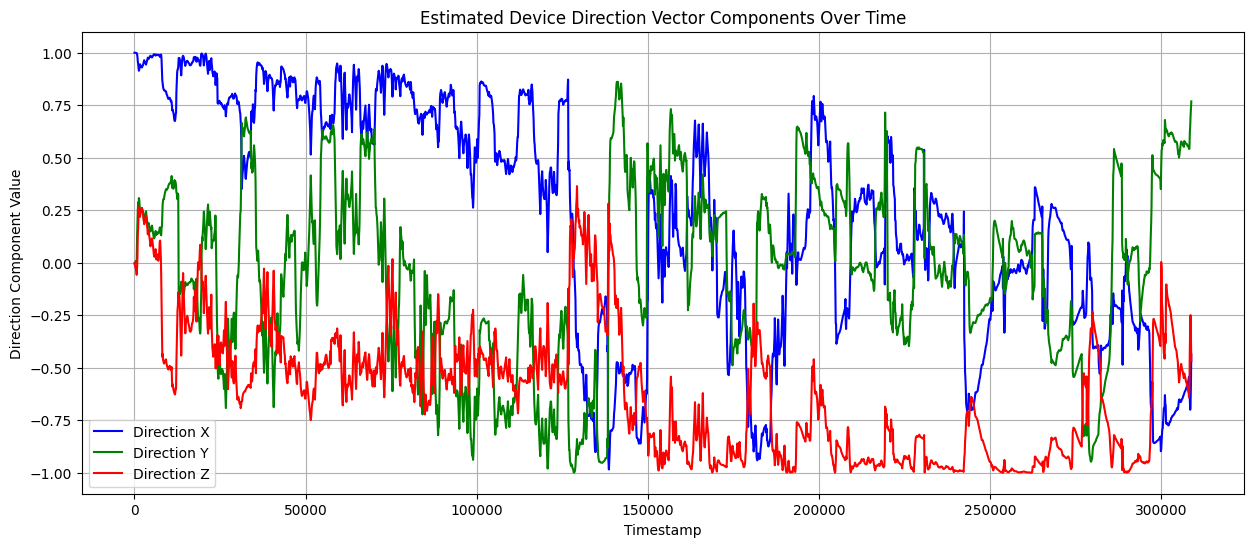

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot dirX
plt.plot(new_df_imu['timestamp2'], new_df_imu['dirX'], label='Direction X', color='blue')

# Plot dirY
plt.plot(new_df_imu['timestamp2'], new_df_imu['dirY'], label='Direction Y', color='green')

# Plot dirZ
plt.plot(new_df_imu['timestamp2'], new_df_imu['dirZ'], label='Direction Z', color='red')

# Add title and labels
plt.title('Estimated Device Direction Vector Components Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Direction Component Value')

# Add legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
import numpy as np

# Initialize position columns
new_df_imu['posX'] = 0.0
new_df_imu['posY'] = 0.0
new_df_imu['posZ'] = 0.0

# Initialize cumulative position variables
cum_posX = 0.0
cum_posY = 0.0
cum_posZ = 0.0

# Iterate through the DataFrame to calculate cumulative positions
for index, row in new_df_imu.iterrows():
    # Add current direction vector components to cumulative position
    cum_posX += row['dirX']
    cum_posY += row['dirY']
    cum_posZ += row['dirZ']

    # Store the cumulative positions in the DataFrame
    new_df_imu.loc[index, 'posX'] = cum_posX
    new_df_imu.loc[index, 'posY'] = cum_posY
    new_df_imu.loc[index, 'posZ'] = cum_posZ

print("Cumulative positions (posX, posY, posZ) added to new_df_imu.")
display(new_df_imu[['dirX', 'dirY', 'dirZ', 'posX', 'posY', 'posZ']].tail(100))

Cumulative positions (posX, posY, posZ) added to new_df_imu.


,dirX,dirY,dirZ,posX,posY,posZ
2750,-0.858987,0.429632,-0.278491,731.823914,-187.629125,-1711.532809
2751,-0.857850,0.428114,-0.284273,730.966064,-187.201010,-1711.817082
2752,-0.856705,0.425277,-0.291884,730.109359,-186.775734,-1712.108966
2753,-0.855471,0.421916,-0.300262,729.253888,-186.353818,-1712.409228
2754,-0.853839,0.419641,-0.307994,728.400049,-185.934177,-1712.717222
...,...,...,...,...,...,...
2845,-0.663582,0.612215,-0.429944,663.484264,-135.573441,-1748.078158
2846,-0.700062,0.652822,-0.289374,662.784202,-134.920619,-1748.367532
2847,-0.671920,0.697305,-0.249577,662.112282,-134.223313,-1748.617108
2848,-0.592703,0.724172,-0.352532,661.519580,-133.499141,-1748.969640


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(x=new_df_imu['posX'], y=new_df_imu['posY'], z=new_df_imu['posZ'],
                                   mode='lines+markers',
                                   marker=dict(size=2, color='blue'),
                                   line=dict(color='blue', width=2))])

fig.update_layout(
    title='3D Plot of Cumulative Position (posX, posY, posZ)',
    scene=dict(
        xaxis_title='X Position',
        yaxis_title='Y Position',
        zaxis_title='Z Position',
        aspectmode='cube' # Ensures equal scaling for axes
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

In [ ]:
df_output = new_df_imu[['timestamp2', 'gyroX', 'gyroY', 'gyroZ', 'Combined_Pitch_Variable', 'Combined_Roll_Variable', 'straight','dx2']].copy()
display(df_output.head(100))

,timestamp2,gyroX,gyroY,gyroZ,Combined_Pitch_Variable,Combined_Roll_Variable,straight,dx2
0,0,-1.50,-0.31,-0.37,NaN,NaN,1,NaN
1,96,1.19,0.06,0.06,NaN,NaN,1,NaN
2,225,1.12,0.06,0.25,-30.823754,-26.256713,1,0.863837
3,321,1.81,0.37,0.56,-31.305293,-26.087021,1,-0.840030
4,418,3.25,-0.25,0.25,-31.305293,-26.087021,1,-0.037959
...,...,...,...,...,...,...,...,...
95,10311,-1.25,-0.75,0.37,-32.097077,-26.111707,1,0.224574
96,10407,1.94,0.06,-0.63,-32.097077,-26.111707,1,-0.052283
97,10503,1.81,0.25,-0.37,-31.079643,-27.691027,1,0.095711
98,10632,1.88,0.44,-0.56,-30.970460,-28.051667,1,0.388624


In [ ]:
import numpy as np

def euler_to_quaternion(phi, theta, psi):
    """Converts Euler angles (roll, pitch, yaw) to a quaternion.

    Args:
        phi (float): Roll angle (φ) in radians.
        theta (float): Pitch angle (θ) in radians.
        psi (float): Yaw angle (ψ) in radians.

    Returns:
        numpy.ndarray: A 4-element array representing the quaternion [q0, q1, q2, q3].
    """
    c_phi_2 = np.cos(phi / 2)
    s_phi_2 = np.sin(phi / 2)
    c_theta_2 = np.cos(theta / 2)
    s_theta_2 = np.sin(theta / 2)
    c_psi_2 = np.cos(psi / 2)
    s_psi_2 = np.sin(psi / 2)

    q0 = c_phi_2 * c_theta_2 * c_psi_2 + s_phi_2 * s_theta_2 * s_psi_2
    q1 = s_phi_2 * c_theta_2 * c_psi_2 - c_phi_2 * s_theta_2 * s_psi_2
    q2 = c_phi_2 * s_theta_2 * c_psi_2 + s_phi_2 * c_theta_2 * s_psi_2
    q3 = c_phi_2 * c_theta_2 * s_psi_2 - s_phi_2 * s_theta_2 * c_psi_2

    return np.array([q0, q1, q2, q3])

print("Function 'euler_to_quaternion' defined successfully.")

Function 'euler_to_quaternion' defined successfully.


In [ ]:
import numpy as np

# Convert pitch and roll to radians, as euler_to_quaternion expects radians
phi_radians = np.radians(new_df_imu['Combined_Roll_Variable'])
theta_radians = np.radians(90 - new_df_imu['Combined_Pitch_Variable'])
psi_radians = 0 # psi is given as 0

df_output['qg0'] = new_df_imu.apply(lambda row: euler_to_quaternion(
    np.radians(row['Combined_Roll_Variable']),
    np.radians(row['Combined_Pitch_Variable']),
    0 # psi is 0
)[0], axis=1)

df_output['qg1'] = new_df_imu.apply(lambda row: euler_to_quaternion(
    np.radians(row['Combined_Roll_Variable']),
    np.radians(row['Combined_Pitch_Variable']),
    0 # psi is 0
)[1], axis=1)

df_output['qg2'] = new_df_imu.apply(lambda row: euler_to_quaternion(
    np.radians(row['Combined_Roll_Variable']),
    np.radians(row['Combined_Pitch_Variable']),
    0 # psi is 0
)[2], axis=1)

df_output['qg3'] = new_df_imu.apply(lambda row: euler_to_quaternion(
    np.radians(row['Combined_Roll_Variable']),
    np.radians(row['Combined_Pitch_Variable']),
    0 # psi is 0
)[3], axis=1)


display(df_output.head())

,timestamp2,gyroX,gyroY,gyroZ,Combined_Pitch_Variable,Combined_Roll_Variable,straight,dx2,qg0,qg1,qg2,qg3
0,0,-1.50,-0.31,-0.37,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,96,1.19,0.06,0.06,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
2,225,1.12,0.06,0.25,-30.823754,-26.256713,1,0.863837,0.938844,-0.218966,-0.258810,-0.060362
3,321,1.81,0.37,0.56,-31.305293,-26.087021,1,-0.840030,0.938071,-0.217321,-0.262843,-0.060892
4,418,3.25,-0.25,0.25,-31.305293,-26.087021,1,-0.037959,0.938071,-0.217321,-0.262843,-0.060892


In [ ]:
df_output['moving'] = ((df_output['dx2'] > 0.2) | (df_output['dx2'] < -0.2)).astype(int)
display(df_output.head(100))

,timestamp2,gyroX,gyroY,gyroZ,Combined_Pitch_Variable,Combined_Roll_Variable,straight,dx2,qg0,qg1,qg2,qg3,moving
0,0,-1.50,-0.31,-0.37,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0
1,96,1.19,0.06,0.06,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0
2,225,1.12,0.06,0.25,-30.823754,-26.256713,1,0.863837,0.938844,-0.218966,-0.258810,-0.060362,1
3,321,1.81,0.37,0.56,-31.305293,-26.087021,1,-0.840030,0.938071,-0.217321,-0.262843,-0.060892,1
4,418,3.25,-0.25,0.25,-31.305293,-26.087021,1,-0.037959,0.938071,-0.217321,-0.262843,-0.060892,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10311,-1.25,-0.75,0.37,-32.097077,-26.111707,1,0.224574,0.936186,-0.217097,-0.269305,-0.062451,1
96,10407,1.94,0.06,-0.63,-32.097077,-26.111707,1,-0.052283,0.936186,-0.217097,-0.269305,-0.062451,0
97,10503,1.81,0.25,-0.37,-31.079643,-27.691027,1,0.095711,0.935451,-0.230557,-0.260124,-0.064112,0
98,10632,1.88,0.44,-0.56,-30.970460,-28.051667,1,0.388624,0.934968,-0.233562,-0.259030,-0.064708,1


In [ ]:
import numpy as np

def quaternion_multiply(q1, q2):
    """Performs quaternion multiplication of two quaternions."""
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2

    return np.array([w, x, y, z])

def euler_rodrigues_quaternion_update(q_initial, gyro_x, gyro_y, gyro_z, dt):
    """Updates the quaternion using Euler-Rodrigues formula with angular velocities.

    Args:
        q_initial (np.ndarray): Initial quaternion [w, x, y, z].
        gyro_x (float): Angular velocity around X-axis.
        gyro_y (float): Angular velocity around Y-axis.
        gyro_z (float): Angular velocity around Z-axis.
        dt (float): Time step.

    Returns:
        np.ndarray: Updated and normalized quaternion.
    """
    # 1. Convert angular velocities to a quaternion (pure quaternion with scalar part 0)
    omega_quat = np.array([0.0, gyro_x, gyro_y, gyro_z])

    # 2. Calculate the derivative of the quaternion: q_dot = 0.5 * q * omega
    q_dot = 0.5 * quaternion_multiply(q_initial, omega_quat)

    # 3. Compute the updated quaternion: q_new = q_initial + q_dot * dt
    q_new = q_initial + q_dot * dt

    # 4. Normalize the new quaternion to ensure it remains a unit quaternion
    q_new = q_new / np.linalg.norm(q_new)

    return q_new

print("Functions 'quaternion_multiply' and 'euler_rodrigues_quaternion_update' defined successfully.")

Functions 'quaternion_multiply' and 'euler_rodrigues_quaternion_update' defined successfully.


In [ ]:
import numpy as np

# Initialize q_updated columns in df_output
df_output['q_updated_0'] = np.nan
df_output['q_updated_1'] = np.nan
df_output['q_updated_2'] = np.nan
df_output['q_updated_3'] = np.nan

# Get the sample period from the kernel state. It was previously defined as 0.01s
sample_period_s = 0.001

# Set the initial quaternion for the first row using Madgwick-filtered values from new_df_imu
initial_q_madgwick = new_df_imu.loc[0, ['q0', 'q1', 'q2', 'q3']].values
df_output.loc[0, ['q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3']] = initial_q_madgwick

# Iterate through df_output to apply conditional quaternion updates
# Start from the second row (index 1) as the first row is already initialized
for i in range(1, len(df_output)):
    current_straight_value = df_output.loc[i, 'straight']
    current_moving_value = df_output.loc[i, 'moving']

    if current_straight_value != 1:
        if current_moving_value == 1:
            # If 'straight' is not 1, update the quaternion using Euler-Rodrigues
            # Use the quaternion from the previous step as q_initial
            q_initial_prev = df_output.loc[i-1, ['q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3']].values

            gyro_x = new_df_imu.loc[i, 'gyroX'] # Use gyro from new_df_imu as it's not in df_output
            gyro_y = new_df_imu.loc[i, 'gyroY'] # Use gyro from new_df_imu
            gyro_z = new_df_imu.loc[i, 'gyroZ'] # Use gyro from new_df_imu

            q_updated = euler_rodrigues_quaternion_update(q_initial_prev, gyro_x, gyro_y, gyro_z, sample_period_s)
            df_output.loc[i, ['q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3']] = q_updated
        else:
          df_output.loc[i, ['q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3']] = \
          df_output.loc[i-1, ['q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3']].values



    else:
        # If 'straight' is 1, keep the quaternion unchanged from the previous step
        df_output.loc[i, ['q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3']] = \
            df_output.loc[i, ['qg0', 'qg1', 'qg2', 'qg3']].values

print("Euler-Rodrigues quaternion updates applied conditionally to df_output.")
display(df_output.head())

Euler-Rodrigues quaternion updates applied conditionally to df_output.


,timestamp2,gyroX,gyroY,gyroZ,Combined_Pitch_Variable,Combined_Roll_Variable,straight,dx2,qg0,qg1,qg2,qg3,moving,q_updated_0,q_updated_1,q_updated_2,q_updated_3
0,0,-1.50,-0.31,-0.37,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,0.999994,-0.002336,0.001504,-0.001850
1,96,1.19,0.06,0.06,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2,225,1.12,0.06,0.25,-30.823754,-26.256713,1,0.863837,0.938844,-0.218966,-0.258810,-0.060362,1,0.938844,-0.218966,-0.258810,-0.060362
3,321,1.81,0.37,0.56,-31.305293,-26.087021,1,-0.840030,0.938071,-0.217321,-0.262843,-0.060892,1,0.938071,-0.217321,-0.262843,-0.060892
4,418,3.25,-0.25,0.25,-31.305293,-26.087021,1,-0.037959,0.938071,-0.217321,-0.262843,-0.060892,0,0.938071,-0.217321,-0.262843,-0.060892


In [ ]:
# Calculate the difference in the 'straight' column to identify changes
straight_diff = df_output['straight'].diff()

# Identify rows where 'straight' changes from 0 to 1
# This means current 'straight' is 1 AND the difference from the previous row is 1 (i.e., it was 0 before)
changes_0_to_1 = df_output[(df_output['straight'] == 1) & (straight_diff == 1)]

print("Rows where 'straight' changes from 0 to 1:")
display(changes_0_to_1.head())

Rows where 'straight' changes from 0 to 1:


,timestamp2,gyroX,gyroY,gyroZ,Combined_Pitch_Variable,Combined_Roll_Variable,straight,dx2,qg0,qg1,qg2,qg3,moving,q_updated_0,q_updated_1,q_updated_2,q_updated_3
1285,139051,0.50,-7.06,2.56,-18.062316,-53.362288,1,0.820955,0.882442,-0.443458,-0.140257,-0.070484,1,0.882442,-0.443458,-0.140257,-0.070484
2475,268156,0.31,-1.00,-0.50,4.908429,-80.738830,1,-0.160291,0.761185,-0.647119,0.032625,0.027736,0,0.761185,-0.647119,0.032625,0.027736


In [ ]:
previous_indices = [idx - 1 for idx in changes_0_to_1.index if idx - 1 >= 0]
if previous_indices:
    print("Rows immediately preceding the changes from 0 to 1:")
    display(df_output.loc[previous_indices].head())
else:
    print("No preceding rows found for the identified changes.")

Rows immediately preceding the changes from 0 to 1:


,timestamp2,gyroX,gyroY,gyroZ,Combined_Pitch_Variable,Combined_Roll_Variable,straight,dx2,qg0,qg1,qg2,qg3,moving,q_updated_0,q_updated_1,q_updated_2,q_updated_3
1284,138923,3.63,-15.31,-1.25,-15.707419,-52.451502,0,-0.617698,0.888646,-0.437764,-0.122578,-0.060384,1,0.895079,-0.244408,-0.371943,0.027524
2474,268060,0.25,1.19,0.50,4.943692,-78.291955,0,0.037947,0.774818,-0.630711,0.033448,0.027227,0,0.900846,-0.425187,-0.081658,0.031987


In [ ]:
import numpy as np

def quaternion_to_yaw(q0, q1, q2, q3):
    """Calculates the yaw angle (rotation around the Z-axis) from quaternion components in degrees."""
    # Calculate yaw in radians using the standard formula
    yaw_radians = np.arctan2(2 * (q1 * q2 + q0 * q3), 1 - 2 * (q2**2 + q3**2))

    # Convert radians to degrees
    yaw_degrees = np.degrees(yaw_radians)

    return yaw_degrees

print("Function 'quaternion_to_yaw' defined successfully.")

Function 'quaternion_to_yaw' defined successfully.


In [ ]:
changes_0_to_1['yaw'] = changes_0_to_1.apply(lambda row: quaternion_to_yaw(row['q_updated_0'], row['q_updated_1'], row['q_updated_2'], row['q_updated_3']), axis=1)

# Calculate yaw for the preceding rows as well
if previous_indices:
    df_output.loc[previous_indices, 'yaw'] = df_output.loc[previous_indices].apply(lambda row: quaternion_to_yaw(row['q_updated_0'], row['q_updated_1'], row['q_updated_2'], row['q_updated_3']), axis=1)
    print("Yaw angles for rows where 'straight' changes from 0 to 1:")
    display(changes_0_to_1[['timestamp2', 'straight', 'q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3', 'yaw']])

    print("\nYaw angles for rows immediately preceding the changes:")
    display(df_output.loc[previous_indices][['timestamp2', 'straight', 'q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3', 'yaw']])
else:
    print("No changes from 'straight' 0 to 1 found, or no preceding rows to calculate yaw.")

Yaw angles for rows where 'straight' changes from 0 to 1:


/tmp/ipython-input-4092483474.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,timestamp2,straight,q_updated_0,q_updated_1,q_updated_2,q_updated_3,yaw
1285,139051,1,0.882442,-0.443458,-0.140257,-0.070484,8.363543e-16
2475,268156,1,0.761185,-0.647119,0.032625,0.027736,0.000000e+00



Yaw angles for rows immediately preceding the changes:


,timestamp2,straight,q_updated_0,q_updated_1,q_updated_2,q_updated_3,yaw
1284,138923,0,0.895079,-0.244408,-0.371943,0.027524,17.752390
2474,268060,0,0.900846,-0.425187,-0.081658,0.031987,7.353735


In [ ]:
import numpy as np

# Calculate z_dirX, z_dirY, z_dirZ using the q_updated quaternion components
df_output['z_dirX_updated'] = 2 * (df_output['q_updated_1'] * df_output['q_updated_3'] + df_output['q_updated_0'] * df_output['q_updated_2'])
df_output['z_dirY_updated'] = 2 * (df_output['q_updated_2'] * df_output['q_updated_3'] - df_output['q_updated_0'] * df_output['q_updated_1'])
df_output['z_dirZ_updated'] = 1 - 2 * (df_output['q_updated_1']**2 + df_output['q_updated_2']**2)

# The dot product of a vector [x, y, z] with [0, 0, 1] is simply z.
# So, the dot product of the updated Z-axis direction vector with [0, 0, 1] is z_dirZ_updated.
df_output['dot_product_with_001'] = df_output['z_dirZ_updated']

print("Calculated z_dirX_updated, z_dirY_updated, z_dirZ_updated, and their dot product with [0,0,1].")
display(df_output[['timestamp2', 'z_dirX_updated', 'z_dirY_updated', 'z_dirZ_updated', 'dot_product_with_001']].head())

Calculated z_dirX_updated, z_dirY_updated, z_dirZ_updated, and their dot product with [0,0,1].


,timestamp2,z_dirX_updated,z_dirY_updated,z_dirZ_updated,dot_product_with_001
0,0,0.003017,0.004665,0.999985,0.999985
1,96,NaN,NaN,NaN,NaN
2,225,-0.459530,0.442394,0.770143,0.770143
3,321,-0.466665,0.439736,0.767370,0.767370
4,418,-0.466665,0.439736,0.767370,0.767370


In [ ]:
changes_0_to_1 = changes_0_to_1.copy()
changes_0_to_1['yaw'] = changes_0_to_1.apply(lambda row: quaternion_to_yaw(row['q_updated_0'], row['q_updated_1'], row['q_updated_2'], row['q_updated_3']), axis=1)

# Calculate yaw for the preceding rows as well
if previous_indices:
    df_output.loc[previous_indices, 'yaw'] = df_output.loc[previous_indices].apply(lambda row: quaternion_to_yaw(row['q_updated_0'], row['q_updated_1'], row['q_updated_2'], row['q_updated_3']), axis=1)
    print("Yaw angles for rows where 'straight' changes from 0 to 1:")
    display(changes_0_to_1[['timestamp2', 'straight', 'q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3', 'yaw']])

    print("\nYaw angles for rows immediately preceding the changes:")
    display(df_output.loc[previous_indices][['timestamp2', 'straight', 'q_updated_0', 'q_updated_1', 'q_updated_2', 'q_updated_3', 'yaw', 'dot_product_with_001', 'moving']])
else:
    print("No changes from 'straight' 0 to 1 found, or no preceding rows to calculate yaw.")

Yaw angles for rows where 'straight' changes from 0 to 1:


,timestamp2,straight,q_updated_0,q_updated_1,q_updated_2,q_updated_3,yaw
1285,139051,1,0.882442,-0.443458,-0.140257,-0.070484,8.363543e-16
2475,268156,1,0.761185,-0.647119,0.032625,0.027736,0.000000e+00



Yaw angles for rows immediately preceding the changes:


,timestamp2,straight,q_updated_0,q_updated_1,q_updated_2,q_updated_3,yaw,dot_product_with_001,moving
1284,138923,0,0.895079,-0.244408,-0.371943,0.027524,17.752390,0.603847,1
2474,268060,0,0.900846,-0.425187,-0.081658,0.031987,7.353735,0.625095,0


In [ ]:
# Calculate 'yaw' for all rows using the q_updated quaternion components
df_output['yaw'] = df_output.apply(lambda row: quaternion_to_yaw(row['q_updated_0'], row['q_updated_1'], row['q_updated_2'], row['q_updated_3']), axis=1)

print("Calculated 'yaw' for all rows in df_output.")
display(df_output[['timestamp2', 'yaw']].head())

Calculated 'yaw' for all rows in df_output.


,timestamp2,yaw
0,0,-2.123960e-01
1,96,NaN
2,225,-9.259283e-16
3,321,-9.306280e-16
4,418,-9.306280e-16


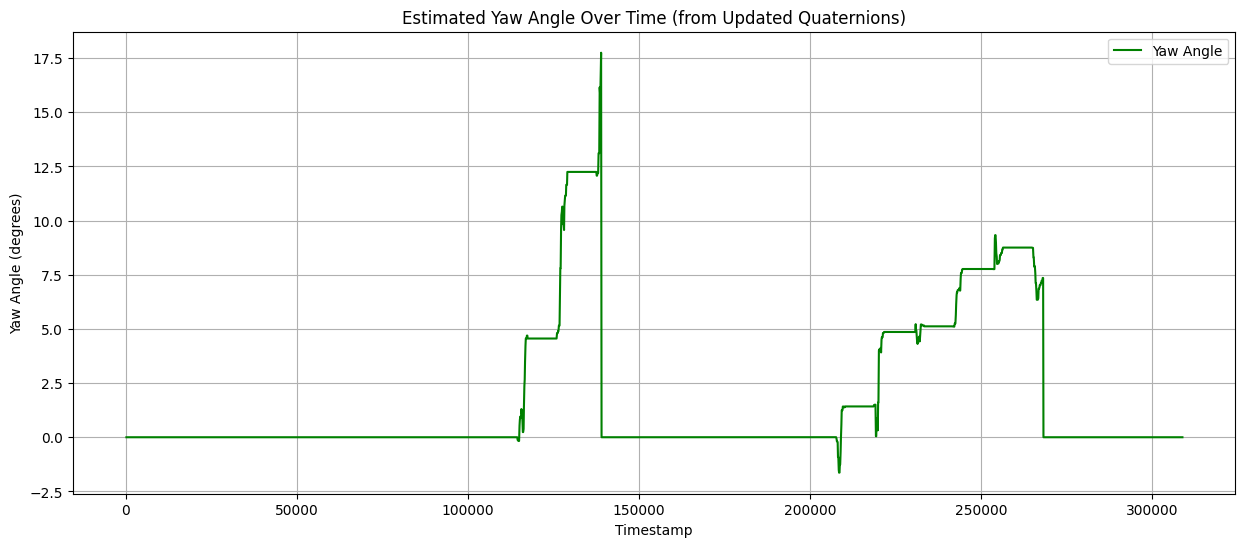

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df_output['timestamp2'], df_output['yaw'], label='Yaw Angle', color='green')
plt.title('Estimated Yaw Angle Over Time (from Updated Quaternions)')
plt.xlabel('Timestamp')
plt.ylabel('Yaw Angle (degrees)')
plt.legend()
plt.grid(True)
plt.show()

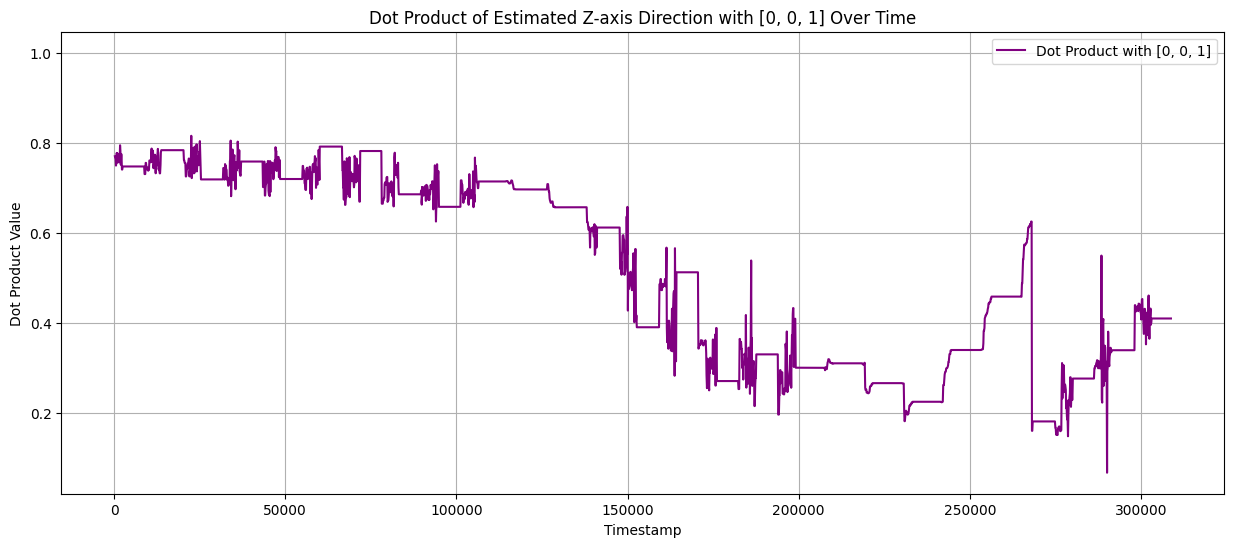

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(df_output['timestamp2'], df_output['dot_product_with_001'], label='Dot Product with [0, 0, 1]', color='purple')
plt.title('Dot Product of Estimated Z-axis Direction with [0, 0, 1] Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Dot Product Value')
plt.legend()
plt.grid(True)
plt.show()